In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import matplotlib

In [2]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [3]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [4]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [5]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [6]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [7]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [8]:
clust["snps_to_clusters"].shape

(500, 11768)

In [9]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single DP iteration

In [10]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [11]:
import scipy.stats
assgn_entropy = scipy.stats.entropy(Cov_clust_probs_overlap, axis=1)
entropy_idx = (assgn_entropy == 0)

#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

Cov_overlap = Cov_overlap.iloc[~naidx]

mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

almost all bins are unanimously assigned

In [12]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

In [13]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [14]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [15]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

In [16]:
Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

In [17]:
cov_18 = Cov_overlap.loc[Cov_overlap['cluster_assgn'] == 18]
r_18 = np.c_[cov_18["covcorr"]]

#making covariate matrix
C_18 = np.c_[np.log(cov_18["C_len"]), cov_18["C_RT_z"], cov_18["C_GC_z"]]

In [18]:
nb_mcmc = nb_cov.NB_MCMC(r, C, Pi)

find ML splitting landscape for reasonable cluster

In [19]:
cov_1 = Cov_overlap.loc[Cov_overlap['cluster_assgn'] == 1]
r_1 = np.c_[cov_1["covcorr"]]

#making covariate matrix
C_1 = np.c_[np.log(cov_1["C_len"]), cov_1["C_RT_z"], cov_1["C_GC_z"]]

In [20]:
def NR_segment(self, ind, ret_hess=False):
    mui_init = np.log(np.exp(np.log(self.r[ind[0]:ind[1]]) - (self.mu) - (self.C[ind[0]:ind[1],:]@self.beta).flatten()).mean())
    lepsi_init = np.log((((np.log(self.r[ind[0]:ind[1]]) - self.mu)**2 / self.mu - 1)).sum() / (ind[1]-ind[0]))
    self.mu_i = mui_init
    self.lepsi_i = self.lepsi_i_arr[ind[0]]
    for it in range(200):
        self.epsi_i = np.exp(self.lepsi_i)
        self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)

        gmu_i = self.gradmu_i(ind)
        hmu_i = self.hessmu_i(ind)
        gepsi_i = self.gradepsi_i(ind)
        hepsi_i = self.hessepsi_i(ind) * self.epsi_i ** 2 + gmu_i * self.epsi_i
        hmuepsi_i = self.hessepsi_i(ind)

        grad = np.r_[gmu_i, gepsi_i * self.epsi_i]
        H = np.r_[np.c_[hmu_i, hmuepsi_i], np.c_[hmuepsi_i, hepsi_i]]
        try:
            inv_H = np.linalg.inv(H)
        except:
            print('singlular matrix')
            self.lepsi_i = ll_gridsearch(ind)
            continue
        
        delta = np.linalg.inv(H) @ grad
        
        print(self.mu_i, self.lepsi_i)
        print('delta:', delta)
        print(gmu_i, gepsi_i)
        print(hmu_i, hepsi_i)
        print('******')
        self.mu_i -= delta[0]
        self.lepsi_i -= delta[1]
        if np.linalg.norm(grad) < 1e-5:
            print('opt reached')
            print(np.linalg.det)
            break
        
        if it == 50:
            self.lepsi_i = ll_gridsearch(ind)
    
    print(ind, self.mu_i, self.lepsi_i)
    # need to theshold due to overflow
    self.lepsi_i = min(self.lepsi_i, 40)
    if ret_hess:
        return self.mu_i, self.lepsi_i, H
    else:
        return self.mu_i, self.lepsi_i

In [21]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [22]:
sNB = statsNB(r_1, np.c_[np.ones(r_1.shape), nb_mcmc.clusters[1].C])

In [23]:
%%time
params = sNB.fit()

Optimization terminated successfully.
         Current function value: 11.531811
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21
CPU times: user 47.9 ms, sys: 28 ms, total: 75.9 ms
Wall time: 39 ms


In [24]:
(np.log(r_1.flatten()) -  (nb_mcmc.clusters[1].C @nb_mcmc.clusters[1].beta).flatten()).shape

(568,)

In [25]:
sNB = statsNB(np.exp(np.log(r_1.flatten()) -  (nb_mcmc.clusters[1].C @nb_mcmc.clusters[1].beta).flatten()), np.ones(r_1.shape))

In [26]:
%%time
params = sNB.fit()

Optimization terminated successfully.
         Current function value: 5.619048
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
CPU times: user 16.8 ms, sys: 12.4 ms, total: 29.1 ms
Wall time: 16.1 ms


In [27]:
params.params

array([5.14800215, 0.16255394])

checking if this could work as a replacement optimizer

In [28]:
sNB = statsNB(np.exp(np.log(r_1[:87].flatten()) -  (nb_mcmc.clusters[1].C[:87] @nb_mcmc.clusters[1].beta).flatten()), np.ones(r_1[:87].shape), exposure = np.ones(r_1[:87].shape[0]) * np.exp(nb_mcmc.clusters[1].mu))

In [106]:
%%time
params = sNB.fit()

Optimization terminated successfully.
         Current function value: 5.461229
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
CPU times: user 12.6 ms, sys: 4.29 ms, total: 16.9 ms
Wall time: 7.75 ms


In [107]:
params.params

array([0.27139089, 0.06149604])

In [94]:
NR_segment(nb_mcmc.clusters[1], (0,87))

0.27139089305595165 1.7835541366465855
delta: [ 0.00147639 -0.59151339]
0.002647623782773778 4.562280282640032
-517.691695146819 -45.90243492808363
******
0.2699145037455712 2.3750675250400795
delta: [-0.00131209 -0.41647492]
1.3904705107685673 1.1574816255594582
-936.6435092300957 -29.880387001714553
******
0.2712265919817519 2.7915424421494004
delta: [-0.00019046  0.1034506 ]
0.2529162147369822 -0.25521402147811134
-1418.5480180469044 -40.22780234653627
******
0.2714170489096139 2.6880918413402632
delta: [ 1.57233518e-05 -1.36759269e-02]
-0.017296766125904806 0.04158465592420679
-1278.9187998858583 -44.709734495052956
******
0.2714013255577993 2.701767768264726
delta: [-2.34557900e-06 -1.76034343e-04]
0.0030763606109638353 0.0005243222826214478
-1296.5460904799265 -44.39536940617566
******
0.2714036711367978 2.7019438026076377
delta: [-2.94357361e-08  1.54434817e-07]
3.814053842920995e-05 -4.599515062153614e-07
-1296.7712597705217 -44.44047556789199
******
0.2714037005725339 2.701943

(0.2714037005467224, 2.701943648318353)

In [119]:
sNB.hessian(params.params)

array([[-1.31966451e+03,  3.70972824e-06],
       [ 3.70972824e-06, -1.00041008e+04]])

In [109]:
np.log(1/params.params[-1])

2.788782435928356

is there a difference in ll though?

In [111]:
nb_mcmc.clusters[1].ll_nbinom(r_1[:87], nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[:87], nb_mcmc.clusters[1].beta, np.ones(r_1[:87].shape[0]) * params.params[0], np.log(1/params.params[-1]))

-1016.320523285521

In [113]:
nb_mcmc.clusters[1].ll_nbinom(r_1[:87],  nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[:87],  nb_mcmc.clusters[1].beta, np.ones(r_1[:87].shape[0]) * 0.2714037005467224,  2.701943648318353)

-1016.148114266288

seems like ours is slightly better, but there still may be some improved stability.

In [129]:
def stats_optimizer(self, ind, ret_hess=False):
    endog = np.exp(np.log(self.r[ind[0]:ind[1]].flatten()) -  (nb_mcmc.clusters[1].C[ind[0]:ind[1]] @nb_mcmc.clusters[1].beta).flatten())
    exog = np.ones(self.r[ind[0]:ind[1]].shape[0])
    exposure = np.ones(self.r[ind[0]:ind[1]].shape[0]) * np.exp(self.mu)
    
    sNB = statsNB(endog, exog, exposure=exposure)
    res = sNB.fit()

    if ret_hess:
        return res.params[0], -np.log(res.params[1]), sNB.hessian(res.params)
    else:
        return res.params[0], -np.log(res.params[1])

In [130]:
stats_optimizer(nb_mcmc.clusters[1], (0,87), True)

Optimization terminated successfully.
         Current function value: 5.461229
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


(0.2713908932412772,
 2.788782435928356,
 array([[-1.31966451e+03,  3.70972824e-06],
        [ 3.70972824e-06, -1.00041008e+04]]))

In [32]:
eps = np.r_[-10:10:0.1]
res = []
for ep in eps:
    res.append(ll_nbinom(nb_mcmc.clusters[1].r[104:316], nb_mcmc.clusters[1].mu, nb_mcmc.clusters[1].C[104:316], nb_mcmc.clusters[5].beta, -0.8, ep))

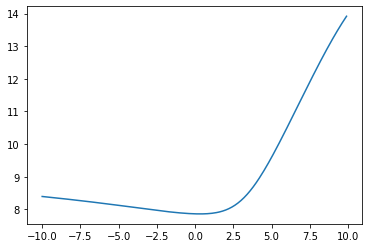

In [33]:
plt.plot(eps, np.log(-np.array(res)))

(2.0, 6.0)

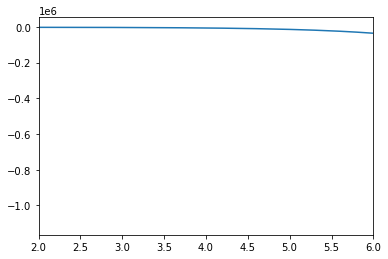

In [34]:
plt.plot(eps, res)
plt.xlim([2,6])

In [44]:
np.log((((np.log(nb_mcmc.clusters[5].r[0:8]) - nb_mcmc.clusters[5].mu)**2 / nb_mcmc.clusters[5].mu - 1)).sum() / (8))

1.745191976399911

In [42]:
nb_mcmc.clusters[5].lepsi_i_arr

array([2.55783166, 2.55783166, 2.55783166, ..., 2.55783166, 2.55783166,
       2.55783166])

In [46]:
NR_segment(nb_mcmc.clusters[5], (0,8))

-0.282208707877504 2.557831663873341
delta: [ 1.57618017e-04 -6.67877490e-01]
0.00017367276712199065 0.21213727787047
-103.2252013703332 -4.09989730014863
******
-0.2823663258943608 3.2257091539931624
delta: [-1.46498729e-04 -4.53682341e-01]
0.03238384282393536 0.05828653949601659
-201.26169849639052 -3.2338792923673365
******
-0.2822198271651559 3.679391494785038
delta: [-1.63631860e-05  2.16172441e-03]
0.005175564717248449 -0.00020834981000827923
-316.6318283392029 -3.818865935648025
******
-0.2822034639791111 3.6772297703792183
delta: [ 2.97646488e-08 -1.12306250e-04]
-9.114841145851926e-06 1.1431555088314838e-05
-315.9436907745452 -4.0244085042780915
******
-0.2822034937437599 3.6773420766294858
delta: [-1.51090995e-09 -1.64162966e-08]
4.77458286241017e-07 1.6707515371194859e-09
-315.97914555341254 -4.024023301180149
******
opt reached
<function det at 0x7f4bfb46ed30>
(0, 8) -0.28220349223284996 3.6773420930457825


(-0.28220349223284996, 3.6773420930457825)

In [27]:
def ll_nbinom(r, mu, C, beta, mu_i, lepsi):
    r = r.flatten()
    epsi = np.exp(lepsi)
    bc = (C @ beta).flatten()
    exp = np.exp(mu + bc + mu_i).flatten()

    return (ss.gammaln(r + epsi) - ss.gammaln(r + 1) - ss.gammaln(epsi) +
            (r * (mu + bc + mu_i - np.log(epsi + exp))) +
            (epsi * np.log(epsi / (epsi + exp)))).sum()

In [28]:
def ll_gridsearch(ind):
    eps = np.r_[-10:10:0.1]
    res = np.zeros(eps.shape)
    r_ind = self.r[ind[0]:ind[1]]
    C_ind = self.C[ind[0]:ind[1]]
    for i, ep in enumerate(eps):
        res[i] = ll_nbinom(r_ind, self.mu, C_ind, self.beta, self.mu_i, ep)
    return eps[np.argmax(res)]

In [46]:
%%time
ll_gridsearch((549,568))

CPU times: user 10.1 ms, sys: 703 µs, total: 10.9 ms
Wall time: 9.31 ms


3.499999999999952

In [37]:
self = nb_mcmc.clusters[1]

In [187]:
nb_mcmc.clusters[1].lepsi_i_arr[555] = 1.78

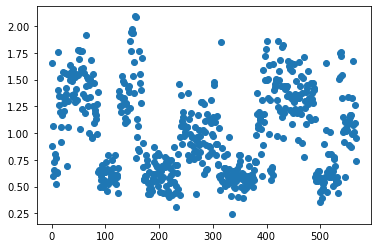

In [24]:
residuals = np.exp(np.log(r_1) - (nb_mcmc.clusters[1].mu) - C_1@nb_mcmc.clusters[1].beta)
plt.scatter(np.r_[:len(r_1)], residuals)

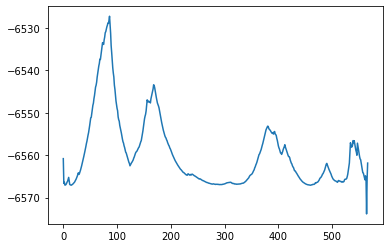

In [35]:
plt.plot(np.r_[:len(lls)], lls)

In [24]:
ML_ratio = []
MH_ratio = []
mls = []
mu_j, eps_j, ML_j = nb_mcmc.clusters[1]._log_ML_join((0,568))
split_probs = np.exp(lls - nb_cov.LSE(lls))
for k in np.r_[1:568]:
    mu_l, lepsi_l, H_l = nb_mcmc.clusters[1].NR_segment((0, k), True)
    mu_r, lepsi_r, H_r = nb_mcmc.clusters[1].NR_segment((k, 568), True)
    ml = nb_mcmc.clusters[1]._get_log_ML_split(H_l, H_r)
    mls.append(ml)
    ML_rat = ml + lls[k-1] - ML_j
    ML_ratio.append(ML_rat)
    MH_ratio.append(ML_rat - nb_mcmc.clusters[1]._log_q_split(np.exp(split_probs[k-1])))

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:157: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:197: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:203: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:200: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

In [25]:
clus =1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())

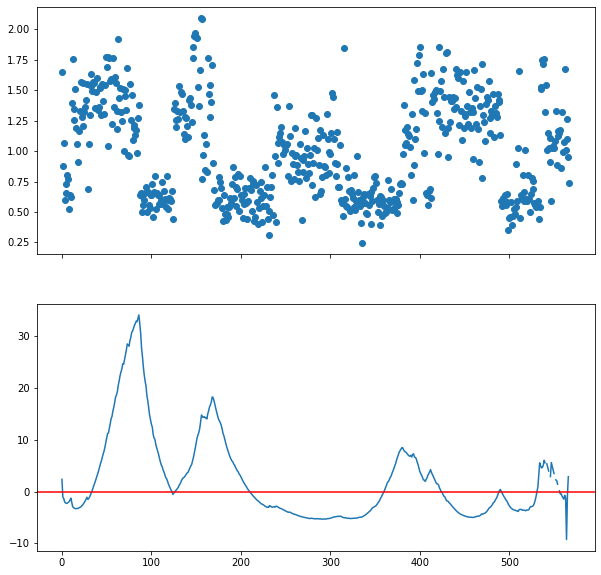

In [27]:
fig, axs = plt.subplots(2, 1, figsize = (10,10), sharex=True)
axs[0].scatter(np.r_[:len(residuals)], residuals)
axs[1].plot(np.r_[:len(lls)], MH_ratio)
axs[1].axhline(0, color='r')

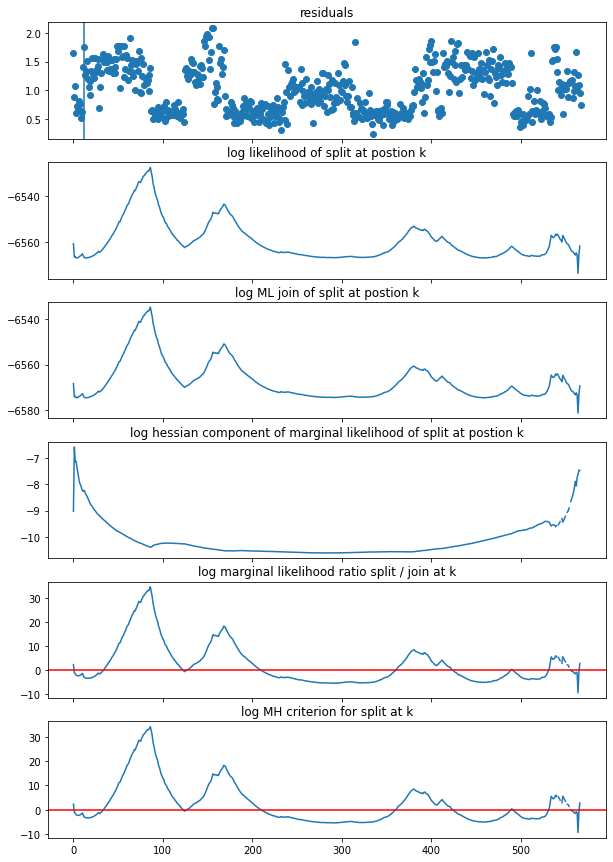

In [34]:
fig, axs = plt.subplots(6, 1, figsize = (10,15), sharex=True)
axs[0].scatter(np.r_[:len(residuals)], residuals)
axs[0].set_title('residuals')
axs[0].axvline(12)
axs[1].set_title('log likelihood of split at postion k')
axs[1].plot(np.r_[:len(lls)], lls)
axs[2].plot(np.r_[:len(lls)], ml + lls)
axs[2].set_title('log ML join of split at postion k')
axs[3].plot(np.r_[:len(lls)], mls)
axs[3].set_title('log hessian component of marginal likelihood of split at postion k')
axs[4].plot(np.r_[:len(lls)], ML_ratio)
axs[4].set_title('log marginal likelihood ratio split / join at k')
axs[5].plot(np.r_[:len(lls)], MH_ratio)
axs[5].set_title('log MH criterion for split at k')
axs[4].axhline(0, color='r')
axs[5].axhline(0, color='r')

In [20]:
lls, break_pick, ll_opt, k_prob, mus_opt, epsi_opt, Hs_opt = nb_mcmc.clusters[1].calc_pk((0,568), debug=True)

optimizing : (0, 1)
failing to converge. Trying grid search
(0, 1) 0.5033187410752633 18.57590995377479
optimizing : (1, 568)
(1, 568) -0.0011545917611532276 1.7815045574272492
optimizing : (0, 2)
(0, 2) 0.23480059178726703 2.321984873274754
optimizing : (2, 568)
(2, 568) -0.0009357535646276801 1.7799517800030644
optimizing : (0, 3)
(0, 3) 0.18162862537239266 2.6337007210697263
optimizing : (3, 568)
(3, 568) -0.0010581668556689746 1.778275321499615
optimizing : (0, 4)
(0, 4) 0.04749152765710701 2.0246140774023162
optimizing : (4, 568)
(4, 568) -0.00034493619476196394 1.7787881810966177
optimizing : (0, 5)
(0, 5) -0.015187540334834866 2.08074013143627
optimizing : (5, 568)
(5, 568) 0.00013392981345326113 1.7779486370410966
optimizing : (0, 6)
(0, 6) -0.07229285477844265 2.0840689293537666
optimizing : (6, 568)
(6, 568) 0.0007444007216067273 1.7777578847507547
optimizing : (0, 7)
(0, 7) -0.09161172805721429 2.2135659406575567
optimizing : (7, 568)
(7, 568) 0.0010918884527353987 1.7764613

In [28]:
nb_mcmc.clusters[5].segment_lens

SortedDict({0: 1211})

In [26]:
lls, break_pick, ll_opt, k_prob, mus_opt, epsi_opt, Hs_opt = nb_mcmc.clusters[5].calc_pk((0,1211))

(0, 1) -0.20885534149163312 18.36750932315711
opt reached
<function det at 0x7f2e3008fd30>
(1, 1211) 0.00015574194146650175 2.5558291401882625
ll:  -13685.190542105305
opt reached
<function det at 0x7f2e3008fd30>
(0, 2) -0.2766010356294931 5.323468723340878
opt reached
<function det at 0x7f2e3008fd30>
(2, 1211) 0.00039951107148611435 2.5561441184057494
ll:  -13686.590229001205
opt reached
<function det at 0x7f2e3008fd30>
(0, 3) -0.3765609583398999 3.6027998321239094
opt reached
<function det at 0x7f2e3008fd30>
(3, 1211) 0.0007789449324068111 2.558551706906225
ll:  -13686.291548217434
opt reached
<function det at 0x7f2e3008fd30>
(0, 4) -0.32148497106922663 3.5587699052947843
opt reached
<function det at 0x7f2e3008fd30>
(4, 1211) 0.0009104302185623656 2.558028685305429
ll:  -13686.174523655809
opt reached
<function det at 0x7f2e3008fd30>
(0, 5) -0.30081372248859006 3.7137588742174055
opt reached
<function det at 0x7f2e3008fd30>
(5, 1211) 0.0010762940138234088 2.5576931985865583
ll:  -136

In [46]:
lls[:100]

array([-6566.85935611, -6566.5968188 , -6567.25739   , -6567.23157844,
       -6567.11923289, -6566.87267495, -6566.55303683, -6566.35112213,
       -6565.92883953, -6565.44575871, -6566.26461283, -6567.11497631,
       -6567.19703209, -6567.25390796, -6567.27917728, -6567.19738025,
       -6567.08994083, -6566.98552464, -6566.83008735, -6566.6780072 ,
       -6566.54913289, -6566.31814716, -6566.07015593, -6565.81051261,
       -6565.49847683, -6565.1559165 , -6564.78056612, -6564.36663191,
       -6564.75183167, -6564.53409245, -6564.1614028 , -6563.7384083 ,
       -6563.27643249, -6562.78302045, -6562.24705484, -6561.67896377,
       -6561.17838068, -6560.59180542, -6559.94315481, -6559.41210128,
       -6558.84728217, -6558.17261203, -6557.47602563, -6556.93573238,
       -6556.1975475 , -6555.52628812, -6554.93807643, -6554.16037891,
       -6553.29261741, -6552.40091049, -6551.44743166, -6551.32128071,
       -6550.34461524, -6549.4409031 , -6548.50328717, -6547.9970824 ,
      

In [27]:
clus =5
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())

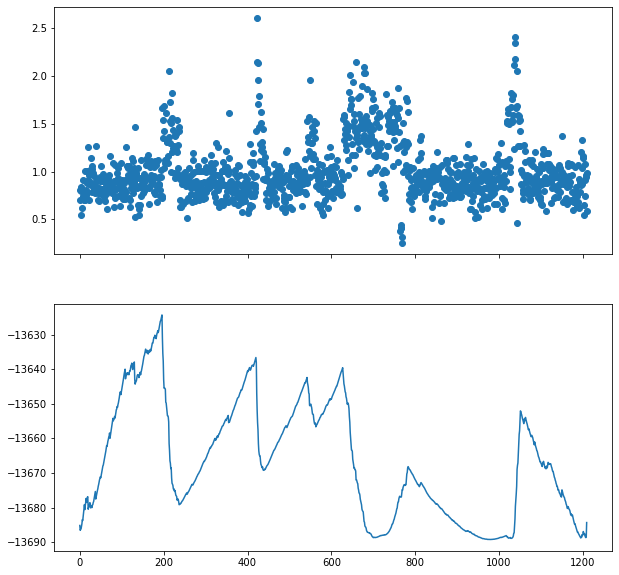

In [28]:
fig, axs = plt.subplots(2, 1, figsize = (10,10), sharex=True)
axs[0].scatter(np.r_[:len(residuals)], residuals)
axs[1].plot(np.r_[:len(lls)], lls)

In [182]:
nb_mcmc.clusters[3].segment_lens

SortedDict({0: 1765})

In [29]:
lls, break_pick, ll_opt, k_prob, mus_opt, epsi_opt, Hs_opt = nb_mcmc.clusters[3].calc_pk((0,1765))

opt reached
<function det at 0x7f2e3008fd30>
(0, 1) -0.0034025199315060786 23.431730240217508
opt reached
<function det at 0x7f2e3008fd30>
(1, 1765) 1.918624609461093e-06 3.1245071133379216
ll:  -19287.273784482568
(0, 2) 0.012384944950091433 28.37531333341802
opt reached
<function det at 0x7f2e3008fd30>
(2, 1765) -1.371834277591101e-05 3.123953030414396
ll:  -19300.776487651965
opt reached
<function det at 0x7f2e3008fd30>
(0, 3) -0.014876649002754542 6.403396756499462
opt reached
<function det at 0x7f2e3008fd30>
(3, 1765) 2.513798574977197e-05 3.1234516770719085
ll:  -19287.82797042258
opt reached
<function det at 0x7f2e3008fd30>
(0, 4) 0.04680299402975411 4.4902240848216275
opt reached
<function det at 0x7f2e3008fd30>
(4, 1765) -0.00010894449684005198 3.1235020037512276
ll:  -19289.95951561666
opt reached
<function det at 0x7f2e3008fd30>
(0, 5) -0.006880873525921818 3.7845884930916935
opt reached
<function det at 0x7f2e3008fd30>
(5, 1765) 1.9501958405202418e-05 3.1237071202747093
ll:

In [30]:
clus =3
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())

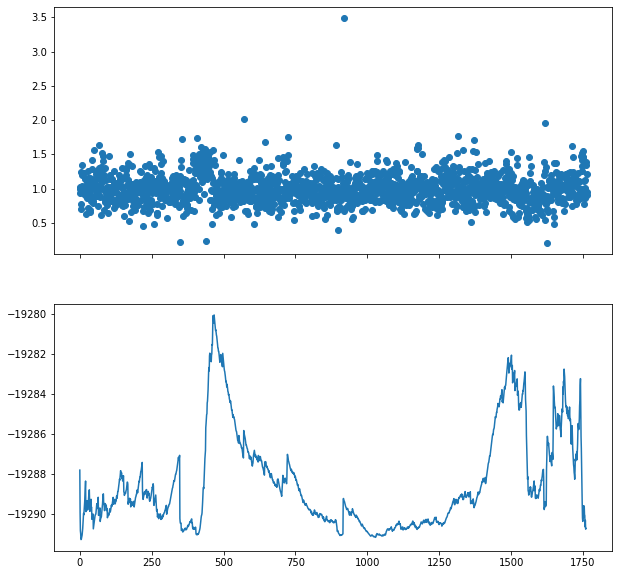

In [31]:
fig, axs = plt.subplots(2, 1, figsize = (10,10), sharex=True)
axs[0].scatter(np.r_[:len(residuals)], residuals)
axs[1].plot(np.r_[:len(lls)-3], lls[2:-1])

In [38]:
nb_mcmc = nb_cov.NB_MCMC(r, C, Pi)

In [40]:
nb_mcmc.clusters[1].segment_lens

SortedDict({0: 85, 11: 557, 85: -74})

In [ ]:
nb_mcmc.run(1000, debug=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

starting MCMC coverage segmentation...
SortedDict({0: 568})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 568)


  0%|          | 1/1000 [00:07<2:07:01,  7.63s/it]

split log ml ratio:  29.759724206131978
split log mh ratio:  30.56882545849112
split!
SortedList([0, 87, 87, 568])
SortedDict({0: 87, 87: 481})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 87)


  0%|          | 2/1000 [00:15<2:13:34,  8.03s/it]

split log ml ratio:  23.35155723835487
split log mh ratio:  26.72418629736876
split!
SortedList([0, 87, 87, 124, 124, 568])
SortedDict({0: 87, 87: 37, 124: 444})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 568)
s_ind: 124 (0, 87)
s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

split log ml ratio:  18.698933067719736
split log mh ratio:  20.98022667351688
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 568])
SortedDict({0: 87, 87: 37, 124: 44, 168: 400})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 568)


  0%|          | 4/1000 [00:30<2:03:25,  7.43s/it]

failing to converge. Trying grid search
split log ml ratio:  -26.568034250518394
split log mh ratio:  -26.283816912919974
SortedDict({0: 87, 87: 37, 124: 44, 168: 400})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 568)


  0%|          | 5/1000 [00:35<1:46:25,  6.42s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 87, 87: 37, 124: 44, 168: 400})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 568)


  1%|          | 6/1000 [00:44<1:58:00,  7.12s/it]

split log ml ratio:  -26.568034042588806
split log mh ratio:  -26.283816704990386
SortedDict({0: 87, 87: 37, 124: 44, 168: 400})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (0, 87)
s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (168, 568)


  1%|          | 7/1000 [00:52<2:06:06,  7.62s/it]

split log ml ratio:  -3.4780336690364493
split log mh ratio:  -0.565926632706578
SortedDict({0: 87, 87: 37, 124: 44, 168: 400})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (0, 87)
s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (168, 568)


  1%|          | 8/1000 [00:58<1:55:53,  7.01s/it]

split log ml ratio:  -0.638783332944513
split log mh ratio:  0.6775462724499444
split!
SortedList([0, 87, 87, 124, 124, 126, 126, 168, 168, 568])
SortedDict({0: 87, 87: 37, 124: 2, 126: 42, 168: 400})
trying to join cluster 1
attempting join on segs: 124 126
join ind:  (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  1%|          | 9/1000 [00:58<1:21:29,  4.93s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
joining!
SortedList([0, 87, 87, 124, 124, 168, 168, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 400})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 568)


  1%|          | 10/1000 [01:07<1:42:04,  6.19s/it]

split log ml ratio:  -23.5926304134573
split log mh ratio:  -19.792298194360228
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 400})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 568)


  1%|          | 11/1000 [01:15<1:51:04,  6.74s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 400})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  1%|          | 12/1000 [01:16<1:22:34,  5.02s/it]/home/opriebe/anaconda

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 400})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 568)


  1%|▏         | 13/1000 [01:24<1:38:07,  5.97s/it]

failing to converge. Trying grid search
split log ml ratio:  -26.56803900511113
split log mh ratio:  -26.28382166751271
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 400})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  1%|▏         | 14/1000 [01:25<1:13:17,  4.46s/it]

failing to converge. Trying grid search
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 400})
trying to split cluster 1
attempting split on segment:  168
ind:  (168, 568)
s_ind: 168 (0, 87)
s_ind: 168 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 168 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 15/1000 [01:34<1:34:33,  5.76s/it]

split log ml ratio:  49.49117591319191
split log mh ratio:  50.626304442978835
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 381, 381, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 187})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 16/1000 [01:38<1:22:19,  5.02s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 187})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 17/1000 [01:39<1:03:15,  3.86s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 187})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 568)
s_ind: 381 (0, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 18/1000 [01:47<1:25:17,  5.21s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaco

split log ml ratio:  34.36424236967014
split log mh ratio:  34.95786043101543
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 381, 381, 491, 491, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 19/1000 [01:48<1:04:45,  3.96s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 168 381
join ind:  (168, 491)


  2%|▏         | 20/1000 [01:52<1:04:26,  3.95s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 77})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 491)
s_ind: 87 (491, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 21/1000 [01:58<1:13:52,  4.53s/it]

failing to converge. Trying grid search
split log ml ratio:  -26.56803385924377
split log mh ratio:  -26.28381652164535
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 22/1000 [02:02<1:11:43,  4.40s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 77})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 568)
s_ind: 491 (0, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 491)


  2%|▏         | 23/1000 [02:08<1:20:10,  4.92s/it]

split log ml ratio:  24.436337718682807
split log mh ratio:  24.47530321546583
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 381, 381, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 33})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▏         | 24/1000 [02:09<1:01:29,  3.78s/it]/home/opriebe/anaconda

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 33})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)
s_ind: 535 (0, 87)
s_ind: 535 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 535 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  2%|▎         | 25/1000 [02:15<1:09:26,  4.27s/it]

split log ml ratio:  0.038095394170341024
split log mh ratio:  0.18506012934449223
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 381, 381, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 491
join ind:  (381, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  3%|▎         | 26/1000 [02:16<55:14,  3.40s/it]  /home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 27/1000 [02:21<1:04:39,  3.99s/it]

split log ml ratio:  -3.5829304594371933
split log mh ratio:  -2.4363853795357504
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 28/1000 [02:28<1:19:27,  4.91s/it]

split log ml ratio:  -3.58293051520468
split log mh ratio:  -2.436385435303237
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 29/1000 [02:29<56:56,  3.52s/it]  

failing to converge. Trying grid search
joining!
SortedList([0, 87, 87, 124, 124, 168, 168, 381, 381, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 491
join ind:  (381, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  3%|▎         | 30/1000 [02:31<49:37,  3.07s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 213, 381: 110, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  168
ind:  (168, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 168 (0, 87)
s_ind: 168 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 168 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 168 (381, 491)
s_ind: 168 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 168 (535, 568)


  3%|▎         | 31/1000 [02:36<1:01:02,  3.78s/it]

split log ml ratio:  17.79914033787827
split log mh ratio:  19.287316428580198
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 316, 316, 381, 381, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 148, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


  3%|▎         | 32/1000 [02:41<1:07:35,  4.19s/it]

failing to converge. Trying grid search
split log ml ratio:  -24.905478827312436
split log mh ratio:  -20.333504064709814
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 148, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  3%|▎         | 33/1000 [02:43<56:11,  3.49s/it]  

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 148, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 316)


  3%|▎         | 34/1000 [02:46<51:28,  3.20s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 148, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 316)


  4%|▎         | 35/1000 [02:48<46:59,  2.92s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 148, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (168, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  4%|▎         | 36/1000 [02:53<57:37,  3.59s/it]

split log ml ratio:  -5.522483806405035
split log mh ratio:  -1.5381783790535337
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 148, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  168
ind:  (168, 316)
s_ind: 168 (0, 87)
s_ind: 168 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 168 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 168 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 168 (381, 491)
s_ind: 168 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 168 (535, 568)


  4%|▎         | 37/1000 [02:59<1:09:10,  4.31s/it]

split log ml ratio:  29.656675880792136
split log mh ratio:  29.94695115721788
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 237, 237, 316, 316, 381, 381, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 69, 237: 79, 316: 65, 381: 110, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 491)
s_ind: 381 (0, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (168, 237)
s_ind: 381 (237, 316)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 381 (535, 568)


  4%|▍         | 38/1000 [03:04<1:11:05,  4.43s/it]

split log ml ratio:  10.34568964767277
split log mh ratio:  10.992186533953827
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 237, 237, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 69, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 87 (0, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (168, 237)
s_ind: 87 (237, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


  4%|▍         | 39/1000 [03:09<1:14:28,  4.65s/it]

failing to converge. Trying grid search
split log ml ratio:  -26.568039004730053
split log mh ratio:  -26.283821667131633
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 69, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  4%|▍         | 40/1000 [03:11<59:54,  3.74s/it]  

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 69, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  168
ind:  (168, 237)
s_ind: 168 (0, 87)
s_ind: 168 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 168 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 168 (237, 316)
s_ind: 168 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 168 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 168 (413, 491)
s_ind: 168 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 168 (535, 568)


  4%|▍         | 41/1000 [03:15<1:05:08,  4.08s/it]

split log ml ratio:  4.204465601785159
split log mh ratio:  5.86641675545161
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 171, 171, 237, 237, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 87)
s_ind: 316 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 568)


  4%|▍         | 42/1000 [03:20<1:08:14,  4.27s/it]

split log ml ratio:  -10.2431301951774
split log mh ratio:  -10.067639937477907
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (171, 237)
s_ind: 491 (237, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  4%|▍         | 43/1000 [03:26<1:13:26,  4.60s/it]

split log ml ratio:  -3.582930515202861
split log mh ratio:  -2.4363854353014176
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 87)
s_ind: 316 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
  4%|▍         | 44/1000 [03:31<1:16:27,  4.80s/it]

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 79, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 316)
s_ind: 237 (0, 87)
s_ind: 237 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 237 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


  4%|▍         | 45/1000 [03:36<1:17:18,  4.86s/it]

split log ml ratio:  -0.312691522564819
split log mh ratio:  1.9919265650496527
split!
SortedList([0, 87, 87, 124, 124, 168, 168, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  5%|▍         | 46/1000 [03:37<57:29,  3.62s/it]  

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  5%|▍         | 47/1000 [03:38<49:29,  3.12s/it]

SortedDict({0: 87, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 87)
s_ind: 0 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 0 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 568)


  5%|▍         | 48/1000 [03:43<57:30,  3.62s/it]

split log ml ratio:  17.79696360820617
split log mh ratio:  17.958054364363306
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 168, 168, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


  5%|▍         | 49/1000 [03:48<1:04:02,  4.04s/it]

split log ml ratio:  -9.56195741229476
split log mh ratio:  -5.983175486944674
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 168 171
join ind:  (168, 237)


  5%|▌         | 50/1000 [03:49<47:54,  3.03s/it]  

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  168
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


  5%|▌         | 52/1000 [03:54<43:25,  2.75s/it]

split log ml ratio:  -9.685217791270588
split log mh ratio:  -5.0150342245915445
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 168 171
join ind:  (168, 237)


  5%|▌         | 53/1000 [03:54<35:08,  2.23s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


  5%|▌         | 54/1000 [03:56<30:20,  1.92s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  6%|▌         | 56/1000 [03:57<23:52,  1.52s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (0, 11)
s_ind: 87 (11, 87)
s_ind: 87 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


  6%|▌         | 57/1000 [04:03<38:47,  2.47s/it]

failing to converge. Trying grid search
split log ml ratio:  -26.568039005208448
split log mh ratio:  -26.283821667610027
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 0 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 568)


  6%|▌         | 59/1000 [04:10<46:44,  2.98s/it]

split log ml ratio:  -2.7526512734984863
split log mh ratio:  -2.424382592822439
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


  6%|▌         | 60/1000 [04:11<37:47,  2.41s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  6%|▌         | 61/1000 [04:12<32:42,  2.09s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 32, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


  6%|▌         | 62/1000 [04:17<46:23,  2.97s/it]

split log ml ratio:  -0.03240930070387549
split log mh ratio:  0.8201857362810188
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 168, 168, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


  6%|▋         | 63/1000 [04:22<56:19,  3.61s/it]

split log ml ratio:  -10.577444320475479
split log mh ratio:  -7.034200962073555
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  6%|▋         | 64/1000 [04:23<42:23,  2.72s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


  6%|▋         | 65/1000 [04:24<33:41,  2.16s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 406)


  7%|▋         | 66/1000 [04:24<26:58,  1.73s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


  7%|▋         | 67/1000 [04:25<24:28,  1.57s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  7%|▋         | 68/1000 [04:26<20:36,  1.33s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


  7%|▋         | 69/1000 [04:28<20:37,  1.33s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)
s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (535, 568)


  7%|▋         | 70/1000 [04:32<36:35,  2.36s/it]

split log ml ratio:  -10.29071612495136
split log mh ratio:  -7.071213385895135
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  7%|▋         | 71/1000 [04:34<32:45,  2.12s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  7%|▋         | 72/1000 [04:35<30:00,  1.94s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 406)


  7%|▋         | 73/1000 [04:36<25:56,  1.68s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  7%|▋         | 74/1000 [04:37<21:20,  1.38s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 406 413
join ind:  (406, 491)


  8%|▊         | 75/1000 [04:38<19:59,  1.30s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  8%|▊         | 76/1000 [04:40<23:05,  1.50s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (11, 87)
s_ind: 406 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 406 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 568)


  8%|▊         | 77/1000 [04:46<41:06,  2.67s/it]

split log ml ratio:  -241.55057949960792
split log mh ratio:  -241.55057949960792
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|▊         | 78/1000 [04:51<53:34,  3.49s/it]

split log ml ratio:  -6.01903942995159
split log mh ratio:  -1.525928924002983
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 406 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 406 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 568)


  8%|▊         | 79/1000 [04:55<58:08,  3.79s/it]

split log ml ratio:  -241.55058009664845
split log mh ratio:  -241.55058009664845
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 406)
s_ind: 381 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (11, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 168)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (406, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


  8%|▊         | 80/1000 [05:01<1:04:21,  4.20s/it]

split log ml ratio:  -5.07067678941803
split log mh ratio:  -1.9414276726374737
SortedDict({0: 11, 11: 76, 87: 37, 124: 44, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 124 168
join ind:  (124, 171)


  8%|▊         | 81/1000 [05:01<46:36,  3.04s/it]  

joining!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


  8%|▊         | 82/1000 [05:06<54:25,  3.56s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.705782858057319
split log mh ratio:  -5.700872263329983
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (0, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 406)
s_ind: 124 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (413, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 124 (535, 568)


  8%|▊         | 83/1000 [05:10<58:31,  3.83s/it]

split log ml ratio:  -6.598779565053519
split log mh ratio:  -3.1046261758156106
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  8%|▊         | 84/1000 [05:11<44:28,  2.91s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  8%|▊         | 85/1000 [05:12<33:41,  2.21s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (0, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 406)
s_ind: 124 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (413, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 124 (535, 568)


  9%|▊         | 86/1000 [05:17<47:33,  3.12s/it]

split log ml ratio:  -6.410273052180855
split log mh ratio:  -2.990886832974865
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning

failing to converge. Trying grid search
failed to optimize:  (11, 124)
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 406
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


  9%|▉         | 89/1000 [05:24<44:11,  2.91s/it]

failing to converge. Trying grid search
split log ml ratio:  -11.103619049637018
split log mh ratio:  -7.755648132708301
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 471, 471, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 406 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 406 (124, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 406)
s_ind: 406 (413, 471)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (471, 491)
s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 406 (535, 568)


  9%|▉         | 90/1000 [05:28<52:56,  3.49s/it]

split log ml ratio:  -241.5505805354842
split log mh ratio:  -241.5505805354842
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (0, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 406)
s_ind: 124 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (413, 471)
s_ind: 124 (471, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 124 (535, 568)


  9%|▉         | 92/1000 [05:33<46:00,  3.04s/it]

split log ml ratio:  -6.696790555375628
split log mh ratio:  -3.080153523586887
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 471)
s_ind: 11 (471, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
  9%|▉         | 93/1000 [05:38<52:45,  3.49s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


  9%|▉         | 94/1000 [05:39<42:38,  2.82s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 471)
s_ind: 491 (471, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|▉         | 95/1000 [05:44<50:39,  3.36s/it]

split log ml ratio:  -3.5829306023215395
split log mh ratio:  -2.4363855224200965
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 406)


 10%|▉         | 96/1000 [05:45<41:10,  2.73s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 471)
s_ind: 11 (471, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (535, 568)


 10%|▉         | 97/1000 [05:50<49:34,  3.29s/it]

split log ml ratio:  -10.09650285054704
split log mh ratio:  -5.0128952206741815
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 535 (124, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 406)
s_ind: 535 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 471)
s_ind: 535 (471, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

split log ml ratio:  0.038096203576969856
split log mh ratio:  0.18506093875112128
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 471, 471, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (124, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 406)
s_ind: 316 (406, 413)
s_ind: 316 (413, 471)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (471, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 10%|▉         | 99/1000 [05:59<1:00:22,  4.02s/it]

split log ml ratio:  -10.243129460388445
split log mh ratio:  -10.067639202688952
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 100/1000 [06:00<43:43,  2.92s/it] 

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 471, 471, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 471)
s_ind: 171 (471, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (535, 568)


 10%|█         | 101/1000 [06:04<51:00,  3.40s/it]

split log ml ratio:  -8.782901014953495
split log mh ratio:  -5.136097993645308
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 10%|█         | 102/1000 [06:05<40:02,  2.68s/it]

failing to converge. Trying grid search
failed to optimize:  (87, 171)
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 406)
s_ind: 381 (0, 11)
s_ind: 381 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (406, 413)
s_ind: 381 (413, 471)
s_ind: 381 (471, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 381 (535, 568)


 10%|█         | 103/1000 [06:10<50:37,  3.39s/it]

split log ml ratio:  -3.5246877776808105
split log mh ratio:  -2.11519825423602
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 87 (0, 11)
s_ind: 87 (11, 87)
s_ind: 87 (124, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 471)
s_ind: 87 (471, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (535, 568)


 10%|█         | 104/1000 [06:15<57:33,  3.85s/it]

failing to converge. Trying grid search
split log ml ratio:  -26.5680294734193
split log mh ratio:  -26.28381213580724
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 471)
s_ind: 11 (471, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (535, 568)


 10%|█         | 105/1000 [06:20<1:02:53,  4.22s/it]

split log ml ratio:  -10.360817958338885
split log mh ratio:  -5.172427700832486
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 406)


 11%|█         | 106/1000 [06:21<47:09,  3.16s/it]  

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 237 (124, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 406)
s_ind: 237 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (413, 471)
s_ind: 237 (471, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (535, 568)


 11%|█         | 107/1000 [06:26<54:02,  3.63s/it]

split log ml ratio:  -4.393397960695438
split log mh ratio:  -1.8709462695987895
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 242, 242, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 471, 471, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 5, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 242)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 237 (124, 171)
s_ind: 237 (171, 237)
s_ind: 237 (242, 313)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 406)
s_ind: 237 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (413, 471)
s_ind: 237 (471, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (535, 568)


 11%|█         | 108/1000 [06:30<58:04,  3.91s/it]

split log ml ratio:  -5.033459165133536
split log mh ratio:  -3.8081437211949383
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 5, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 242)
s_ind: 171 (242, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 471)
s_ind: 171 (471, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (535, 568)


 11%|█         | 109/1000 [06:35<1:03:48,  4.30s/it]

split log ml ratio:  -9.83962788572535
split log mh ratio:  -5.7618037682259455
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 5, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 124 171
join ind:  (124, 237)


 11%|█         | 110/1000 [06:37<49:48,  3.36s/it]  

failing to converge. Trying grid search
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 5, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  242
ind:  (242, 313)
s_ind: 242 (0, 11)
s_ind: 242 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 242 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 242 (124, 171)
s_ind: 242 (171, 237)
s_ind: 242 (237, 242)
s_ind: 242 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 242 (381, 406)
s_ind: 242 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 242 (413, 471)
s_ind: 242 (471, 491)
s_ind: 242 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 242 (535, 568)


 11%|█         | 111/1000 [06:41<54:57,  3.71s/it]

split log ml ratio:  -8.342123823647853
split log mh ratio:  -3.7727630697772847
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 5, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 242)


 11%|█         | 112/1000 [06:42<41:18,  2.79s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 5, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 237 242
join ind:  (237, 313)


 11%|█▏        | 113/1000 [06:42<31:30,  2.13s/it]

joining!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 471, 471, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (124, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 406)
s_ind: 316 (406, 413)
s_ind: 316 (413, 471)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (471, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (535, 568)


 11%|█▏        | 114/1000 [06:47<44:03,  2.98s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.24313008741592
split log mh ratio:  -10.067639829707332
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 471)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (471, 491)
s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 413 (535, 568)


 12%|█▏        | 115/1000 [06:52<50:35,  3.43s/it]

split log ml ratio:  -8.019811455887975
split log mh ratio:  -4.330498078459641
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 471)
s_ind: 11 (471, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (535, 568)


 12%|█▏        | 116/1000 [06:57<56:39,  3.85s/it]

split log ml ratio:  -8.905248756433139
split log mh ratio:  -6.164357796282275
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 471)
s_ind: 171 (471, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (535, 568)


 12%|█▏        | 117/1000 [07:01<1:00:43,  4.13s/it]

split log ml ratio:  -9.816595413023606
split log mh ratio:  -6.276661441195756
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 12%|█▏        | 118/1000 [07:02<47:27,  3.23s/it]  

failing to converge. Trying grid search
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 471)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (471, 491)
s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 413 (535, 568)


 12%|█▏        | 119/1000 [07:07<54:36,  3.72s/it]

split log ml ratio:  -8.413899275503354
split log mh ratio:  -4.412230218556942
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 471 491
join ind:  (471, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 12%|█▏        | 120/1000 [07:08<40:30,  2.76s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 171)


 12%|█▏        | 121/1000 [07:09<33:05,  2.26s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (0, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 406)
s_ind: 124 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (413, 471)
s_ind: 124 (471, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 124 (535, 568)


 12%|█▏        | 122/1000 [07:14<45:38,  3.12s/it]

split log ml ratio:  -4.835327987500932
split log mh ratio:  -1.0211694249301217
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (0, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 406)
s_ind: 124 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (413, 471)
s_ind: 124 (471, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 124 (535, 568)


 12%|█▏        | 123/1000 [07:19<53:34,  3.67s/it]

split log ml ratio:  -5.067595356260426
split log mh ratio:  -3.050137447018642
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 471)
s_ind: 171 (471, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (535, 568)


 12%|█▏        | 124/1000 [07:23<57:04,  3.91s/it]

split log ml ratio:  -10.343081280472688
split log mh ratio:  -5.956527152855415
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning

failing to converge. Trying grid search
failed to optimize:  (11, 124)
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 237 313
join ind:  (237, 316)


 13%|█▎        | 126/1000 [07:26<37:18,  2.56s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 471)
s_ind: 171 (471, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (535, 568)


 13%|█▎        | 127/1000 [07:31<47:44,  3.28s/it]

split log ml ratio:  -11.165830504585756
split log mh ratio:  -6.880533929856028
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 0 (124, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 406)
s_ind: 0 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (413, 471)
s_ind: 0 (471, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (535, 568)


 13%|█▎        | 128/1000 [07:35<52:20,  3.60s/it]

split log ml ratio:  -2.752651273534866
split log mh ratio:  -2.4243825928715528
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 471)
s_ind: 171 (471, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (535, 568)


 13%|█▎        | 130/1000 [07:40<43:35,  3.01s/it]

split log ml ratio:  -8.782901360740652
split log mh ratio:  -5.136098339455202
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 471)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (471, 491)
s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarn

s_ind: 413 (535, 568)


 13%|█▎        | 131/1000 [07:45<49:33,  3.42s/it]

split log ml ratio:  -6.016665436181938
split log mh ratio:  -3.6023576399020385
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 124 171
join ind:  (124, 237)


 13%|█▎        | 132/1000 [07:46<42:35,  2.94s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 58, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 471
join ind:  (413, 491)


 13%|█▎        | 133/1000 [07:47<34:11,  2.37s/it]

joining!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 406, 406, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 25, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 406
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 14%|█▎        | 135/1000 [07:48<21:06,  1.46s/it]

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (124, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 568)


 14%|█▎        | 136/1000 [07:53<34:50,  2.42s/it]

failing to converge. Trying grid search
split log ml ratio:  -9.03011152990166
split log mh ratio:  -5.1885392683507225
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 14%|█▎        | 137/1000 [07:54<31:07,  2.16s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 14%|█▍        | 138/1000 [07:56<26:31,  1.85s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 14%|█▍        | 139/1000 [07:57<23:38,  1.65s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 14%|█▍        | 140/1000 [07:58<22:50,  1.59s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 14%|█▍        | 141/1000 [08:03<38:23,  2.68s/it]

split log ml ratio:  -4.582367038235134
split log mh ratio:  -1.7771153442472496
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 32, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


 14%|█▍        | 142/1000 [08:08<47:47,  3.34s/it]

split log ml ratio:  -0.3124242385829348
split log mh ratio:  0.7360821548045351
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (124, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 405)
s_ind: 316 (405, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 14%|█▍        | 143/1000 [08:13<54:33,  3.82s/it]

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


 14%|█▍        | 144/1000 [08:18<59:52,  4.20s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.413823076580229
split log mh ratio:  -5.117142710435473
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 87 (0, 11)
s_ind: 87 (11, 87)
s_ind: 87 (124, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (381, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


 14%|█▍        | 145/1000 [08:23<1:03:26,  4.45s/it]

failing to converge. Trying grid search
split log ml ratio:  -23.59087484403608
split log mh ratio:  -19.84764143578286
SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 15%|█▍        | 146/1000 [08:25<50:45,  3.57s/it]  

SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 405 413
join ind:  (405, 491)


 15%|█▍        | 147/1000 [08:26<39:49,  2.80s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 0 (124, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 405)
s_ind: 0 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 568)


 15%|█▍        | 148/1000 [08:31<49:33,  3.49s/it]

split log ml ratio:  -2.9332939043852093
split log mh ratio:  -0.41599145740383303
split!
SortedList([0, 2, 2, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 15%|█▍        | 149/1000 [08:33<42:11,  2.97s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (2, 11)
s_ind: 405 (11, 87)
s_ind: 405 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 405 (124, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 313)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 568)


 15%|█▌        | 150/1000 [08:38<51:15,  3.62s/it]

split log ml ratio:  -241.69089393762988
split log mh ratio:  -241.69089393762988
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (2, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 413 (124, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (381, 405)
s_ind: 413 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


 15%|█▌        | 151/1000 [08:43<57:30,  4.06s/it]

split log ml ratio:  -10.743830889980927
split log mh ratio:  -7.0061336596800174
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (2, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 405)
s_ind: 124 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 124 (413, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 124 (535, 568)


 15%|█▌        | 152/1000 [08:48<59:32,  4.21s/it]

split log ml ratio:  -6.210081505893868
split log mh ratio:  -3.1395228465135006
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (2, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)
s_ind: 11 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


 15%|█▌        | 153/1000 [08:52<1:01:39,  4.37s/it]

split log ml ratio:  -8.886270630297076
split log mh ratio:  -5.201654755675008
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 237 313
join ind:  (237, 316)


 15%|█▌        | 154/1000 [08:53<45:43,  3.24s/it]  /home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (2, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 16%|█▌        | 155/1000 [08:58<51:29,  3.66s/it]

split log ml ratio:  -3.964215958511886
split log mh ratio:  -2.3378907643364073
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 405)
s_ind: 381 (2, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (11, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


 16%|█▌        | 156/1000 [09:03<58:56,  4.19s/it]

split log ml ratio:  -1.5181600143923788
split log mh ratio:  -1.0590222159671612
split!
SortedList([0, 2, 2, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 397, 397, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  2
ind:  (2, 11)
s_ind: 2 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 2 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 2 (124, 171)
s_ind: 2 (171, 237)
s_ind: 2 (237, 313)
s_ind: 2 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 2 (381, 397)
s_ind: 2 (397, 405)
s_ind: 2 (405, 413)
s_ind: 2 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 2 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 2 (535, 568)


 16%|█▌        | 157/1000 [09:09<1:08:40,  4.89s/it]

split log ml ratio:  -8.440202465415496
split log mh ratio:  -6.702771930690688
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 2 11
join ind:  (2, 87)


 16%|█▌        | 158/1000 [09:11<53:13,  3.79s/it]  

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 124 171
join ind:  (124, 237)


 16%|█▌        | 160/1000 [09:12<33:59,  2.43s/it]

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (2, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 397)
s_ind: 11 (397, 405)
s_ind: 11 (405, 413)
s_ind: 11 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


 16%|█▌        | 161/1000 [09:20<50:12,  3.59s/it]

split log ml ratio:  -9.314341304554546
split log mh ratio:  -5.159736615796647
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 87 (2, 11)
s_ind: 87 (11, 87)
s_ind: 87 (124, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (381, 397)
s_ind: 87 (397, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


 16%|█▌        | 162/1000 [09:26<59:43,  4.28s/it]

split log ml ratio:  -26.568034042682484
split log mh ratio:  -26.283816705084064
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  397
ind:  (397, 405)
s_ind: 397 (2, 11)
s_ind: 397 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 397 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 397 (124, 171)
s_ind: 397 (171, 237)
s_ind: 397 (237, 313)
s_ind: 397 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 397 (381, 397)
s_ind: 397 (405, 413)
s_ind: 397 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 397 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 397 (535, 568)


 16%|█▋        | 163/1000 [09:30<1:00:49,  4.36s/it]

split log ml ratio:  -12.322153526986767
split log mh ratio:  -11.627304374031155
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning

failing to converge. Trying grid search
failed to optimize:  (11, 124)
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 397)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 16%|█▋        | 165/1000 [09:33<39:37,  2.85s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 17%|█▋        | 166/1000 [09:33<29:07,  2.10s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547:

failing to converge. Trying grid search
failed to optimize:  (397, 413)
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (2, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (381, 397)
s_ind: 491 (397, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 17%|█▋        | 167/1000 [09:39<42:29,  3.06s/it]

split log ml ratio:  -3.9642159585810077
split log mh ratio:  -2.337890764405529
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 17%|█▋        | 168/1000 [09:39<32:18,  2.33s/it]

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 405 413
join ind:  (405, 491)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 17%|█▋        | 169/1000 [09:40<25:54,  1.87s/it]

failing to converge. Trying grid search
failed to optimize:  (405, 491)
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (2, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 535 (124, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (381, 397)
s_ind: 535 (397, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 17%|█▋        | 170/1000 [09:45<38:03,  2.75s/it]

split log ml ratio:  0.038096177795523545
split log mh ratio:  0.18506091296876548
split!
SortedList([0, 2, 2, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 397, 397, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (2, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 542 (124, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 313)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 542 (381, 397)
s_ind: 542 (397, 405)
s_ind: 542 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.812134578474797
split log mh ratio:  -5.896335794062907
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 17%|█▋        | 172/1000 [09:50<34:43,  2.52s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)
failing to converge. Trying grid search
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (2, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 535 (124, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (381, 397)
s_ind: 535 (397, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 18%|█▊        | 175/1000 [09:55<31:27,  2.29s/it]

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (2, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 397)
s_ind: 11 (397, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 18%|█▊        | 176/1000 [10:00<43:15,  3.15s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (2, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (381, 397)
s_ind: 11 (397, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 18%|█▊        | 177/1000 [10:05<50:36,  3.69s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

failing to converge. Trying grid search
split log ml ratio:  -10.385943269429845
split log mh ratio:  -5.229204689321705
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  2
ind:  (2, 11)
s_ind: 2 (11, 87)
s_ind: 2 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 2 (124, 171)
s_ind: 2 (171, 237)
s_ind: 2 (237, 313)
s_ind: 2 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 2 (381, 397)
s_ind: 2 (397, 405)
s_ind: 2 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 2 (413, 491)
s_ind: 2 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 2 (535, 542)
s_ind: 2 (542, 568)


 18%|█▊        | 180/1000 [10:11<39:34,  2.90s/it]

split log ml ratio:  -8.759930118803823
split log mh ratio:  -7.387259255119716
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 2 11
join ind:  (2, 87)


 18%|█▊        | 181/1000 [10:12<31:26,  2.30s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (2, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 535 (124, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (381, 397)
s_ind: 535 (397, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 18%|█▊        | 183/1000 [10:18<36:20,  2.67s/it]

SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (2, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (381, 397)
s_ind: 11 (397, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 18%|█▊        | 184/1000 [10:23<46:41,  3.43s/it]

split log ml ratio:  -6.995954759309825
split log mh ratio:  -5.348968294867518
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning

failing to converge. Trying grid search
failed to optimize:  (11, 124)
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 19%|█▊        | 186/1000 [10:27<33:11,  2.45s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 19%|█▊        | 187/1000 [10:27<24:21,  1.80s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 19%|█▉        | 188/1000 [10:27<18:38,  1.38s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 397)
s_ind: 381 (2, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 381 (124, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (397, 405)
s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


 19%|█▉        | 190/1000 [10:32<22:50,  1.69s/it]

split log ml ratio:  -7.163742677335904
split log mh ratio:  -5.789474280991271
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 397
join ind:  (381, 405)
joining!
SortedList([0, 2, 2, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (2, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 19%|█▉        | 192/1000 [10:37<28:02,  2.08s/it]

split log ml ratio:  -4.959919348548283
split log mh ratio:  -1.5447219115303605
SortedDict({0: 2, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 2
join ind:  (0, 11)
joining!
SortedList([0, 11, 11, 87, 87, 124, 124, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (124, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|█▉        | 195/1000 [10:44<32:06,  2.39s/it]

split log ml ratio:  -3.5829305152055895
split log mh ratio:  -2.4363854353050556
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 20%|█▉        | 196/1000 [10:45<28:33,  2.13s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (124, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 20%|█▉        | 197/1000 [10:50<38:40,  2.89s/it]

failing to converge. Trying grid search
split log ml ratio:  -9.147945801707465
split log mh ratio:  -5.3664187185204355
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 237 (124, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 405)
s_ind: 237 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 20%|█▉        | 198/1000 [10:55<44:51,  3.36s/it]

split log ml ratio:  -3.283947469391933
split log mh ratio:  -1.3562555358348618
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 47, 126: 42, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 171)
s_ind: 124 (0, 11)
s_ind: 124 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 124 (171, 237)
s_ind: 124 (237, 313)
s_ind: 124 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 124 (381, 405)
s_ind: 124 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 124 (413, 491)
s_ind: 124 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 124 (535, 542)
s_ind: 124 (542, 568)


 20%|█▉        | 199/1000 [11:00<50:26,  3.78s/it]

split log ml ratio:  -1.3318583290820243
split log mh ratio:  0.7207928711668505
split!
SortedList([0, 11, 11, 87, 87, 124, 124, 126, 126, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 20%|██        | 200/1000 [11:00<37:40,  2.83s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 20%|██        | 201/1000 [11:03<35:29,  2.66s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 11 (126, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 20%|██        | 202/1000 [11:08<45:09,  3.40s/it]

split log ml ratio:  -11.771735032685683
split log mh ratio:  -5.2818479201851005
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 405)


 20%|██        | 203/1000 [11:09<36:19,  2.73s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (126, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 405)
s_ind: 316 (405, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 20%|██        | 204/1000 [11:14<45:32,  3.43s/it]

split log ml ratio:  -10.243131410814385
split log mh ratio:  -10.067641153114891
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 20%|██        | 205/1000 [11:15<36:13,  2.73s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 124)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 171 (126, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 405)
s_ind: 171 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 21%|██        | 206/1000 [11:20<46:00,  3.48s/it]

split log ml ratio:  -9.271648444141647
split log mh ratio:  -5.324967378162
SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 124 126
join ind:  (124, 171)


 21%|██        | 207/1000 [11:21<33:41,  2.55s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 37, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 126)


 21%|██        | 208/1000 [11:21<24:52,  1.88s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 21%|██        | 209/1000 [11:23<24:31,  1.86s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 126)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 45, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 171)
s_ind: 126 (0, 11)
s_ind: 126 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (171, 237)
s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 405)
s_ind: 126 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 21%|██        | 210/1000 [11:28<37:33,  2.85s/it]

split log ml ratio:  -0.8760448648681631
split log mh ratio:  0.7180545878854905
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (145, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (381, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 21%|██        | 211/1000 [11:33<46:03,  3.50s/it]

failing to converge. Trying grid search
failed to optimize:  (87, 126)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 21%|██        | 212/1000 [11:34<34:55,  2.66s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 21%|██▏       | 213/1000 [11:36<32:13,  2.46s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/s

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


 21%|██▏       | 214/1000 [11:36<23:52,  1.82s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 145)
s_ind: 237 (145, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 405)
s_ind: 237 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


 22%|██▏       | 215/1000 [11:41<38:17,  2.93s/it]

split log ml ratio:  -3.2839474691463693
split log mh ratio:  -1.3562555355892982
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 145)
s_ind: 11 (145, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 22%|██▏       | 216/1000 [11:47<48:26,  3.71s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 26, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  145
ind:  (145, 171)
s_ind: 145 (0, 11)
s_ind: 145 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 145 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 145 (126, 145)
s_ind: 145 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 145 (237, 313)
s_ind: 145 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 145 (381, 405)
s_ind: 145 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 145 (413, 491)
s_ind: 145 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 145 (535, 568)


 22%|██▏       | 217/1000 [11:52<53:07,  4.07s/it]

split log ml ratio:  -1.6294163255870444
split log mh ratio:  0.5842201921550441
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 145)
s_ind: 237 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 405)
s_ind: 237 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


 22%|██▏       | 218/1000 [11:57<57:30,  4.41s/it]

split log ml ratio:  -8.749573427234282
split log mh ratio:  -4.452852546357463
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 22%|██▏       | 219/1000 [11:58<43:50,  3.37s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 568)


 22%|██▏       | 220/1000 [11:59<33:29,  2.58s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 568)


 22%|██▏       | 221/1000 [11:59<25:54,  2.00s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 145)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (145, 156)
s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 405)
s_ind: 126 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 568)


 22%|██▏       | 222/1000 [12:04<36:22,  2.80s/it]

failing to converge. Trying grid search
split log ml ratio:  -15.677853187723485
split log mh ratio:  -13.83303871563021
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 405)
s_ind: 381 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 145)
s_ind: 381 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


 22%|██▏       | 223/1000 [12:09<46:07,  3.56s/it]

split log ml ratio:  -1.5181635756880496
split log mh ratio:  -1.0590257772628324
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 405)


 22%|██▏       | 224/1000 [12:10<35:13,  2.72s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 22%|██▎       | 225/1000 [12:11<28:56,  2.24s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 24, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 405)
s_ind: 381 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 145)
s_ind: 381 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


 23%|██▎       | 226/1000 [12:16<39:21,  3.05s/it]

split log ml ratio:  -1.5181635757044205
split log mh ratio:  -1.0590257772792033
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 397, 397, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (145, 156)
s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (381, 397)
s_ind: 237 (397, 405)
s_ind: 237 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


 23%|██▎       | 227/1000 [12:21<46:21,  3.60s/it]

split log ml ratio:  -10.09691940691755
split log mh ratio:  -4.504045729264362
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 23%|██▎       | 228/1000 [12:22<34:46,  2.70s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 23%|██▎       | 229/1000 [12:22<26:33,  2.07s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  145
ind:  (145, 156)
s_ind: 145 (0, 11)
s_ind: 145 (11, 87)
s_ind: 145 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 145 (126, 145)
s_ind: 145 (156, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 145 (171, 237)
s_ind: 145 (237, 313)
s_ind: 145 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 145 (381, 397)
s_ind: 145 (397, 405)
s_ind: 145 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 145 (413, 491)
s_ind: 145 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 145 (535, 568)


 23%|██▎       | 230/1000 [12:28<38:27,  3.00s/it]

split log ml ratio:  -9.751182767975479
split log mh ratio:  -7.4386487225792735
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 23%|██▎       | 231/1000 [12:28<29:36,  2.31s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 145)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (145, 156)
s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (381, 397)
s_ind: 126 (397, 405)
s_ind: 126 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 568)


 23%|██▎       | 232/1000 [12:33<40:19,  3.15s/it]

split log ml ratio:  -17.063331051454952
split log mh ratio:  -14.40594986879023
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 397)
s_ind: 381 (0, 11)
s_ind: 381 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 145)
s_ind: 381 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (397, 405)
s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


 23%|██▎       | 233/1000 [12:38<45:55,  3.59s/it]

split log ml ratio:  -7.163742497325984
split log mh ratio:  -5.789474100982261
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 23%|██▎       | 234/1000 [12:39<34:37,  2.71s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 237 313
join ind:  (237, 316)


 24%|██▎       | 235/1000 [12:39<26:28,  2.08s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 24%|██▎       | 236/1000 [12:40<20:42,  1.63s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 24%|██▎       | 237/1000 [12:40<16:42,  1.31s/it]

failing to converge. Trying grid search
failed to optimize:  (87, 145)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (0, 11)
s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (145, 156)
s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 397)
s_ind: 126 (397, 405)
s_ind: 126 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 568)


 24%|██▍       | 238/1000 [12:45<30:36,  2.41s/it]

failing to converge. Trying grid search
split log ml ratio:  -16.435914819012396
split log mh ratio:  -14.019242860216764
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 145)
s_ind: 87 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (381, 397)
s_ind: 87 (397, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


 24%|██▍       | 239/1000 [12:51<41:22,  3.26s/it]

failing to converge. Trying grid search
split log ml ratio:  -6.284721954588349
split log mh ratio:  -4.1870878212957905
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 24%|██▍       | 240/1000 [12:51<32:14,  2.55s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (145, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (381, 397)
s_ind: 413 (397, 405)
s_ind: 413 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


 24%|██▍       | 241/1000 [12:57<41:49,  3.31s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.882509004653912
split log mh ratio:  -6.966829683102333
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 145)
s_ind: 87 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 397)
s_ind: 87 (397, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


 24%|██▍       | 242/1000 [13:02<49:21,  3.91s/it]

split log ml ratio:  -10.928371546477138
split log mh ratio:  -6.26018923364245
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 145)
s_ind: 171 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (156, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (381, 397)
s_ind: 171 (397, 405)
s_ind: 171 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 568)


 24%|██▍       | 243/1000 [13:07<53:53,  4.27s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

split log ml ratio:  -10.462029672114113
split log mh ratio:  -6.6611680920268554
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 145)
s_ind: 535 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 397)
s_ind: 535 (397, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 24%|██▍       | 245/1000 [13:12<43:53,  3.49s/it]

split log ml ratio:  0.03809620358515531
split log mh ratio:  0.18506093875930674
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 397, 397, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 397)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 25%|██▍       | 246/1000 [13:12<33:39,  2.68s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 25%|██▍       | 247/1000 [13:13<26:00,  2.07s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 25%|██▍       | 248/1000 [13:15<26:25,  2.11s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 145)
s_ind: 413 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (381, 397)
s_ind: 413 (397, 405)
s_ind: 413 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 25%|██▍       | 249/1000 [13:20<37:39,  3.01s/it]

split log ml ratio:  -11.739750144635764
split log mh ratio:  -6.8099230935313235
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 25%|██▌       | 251/1000 [13:22<24:17,  1.95s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 145)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (0, 11)
s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (145, 156)
s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 126 (381, 397)
s_ind: 126 (397, 405)
s_ind: 126 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 25%|██▌       | 254/1000 [13:27<22:41,  1.82s/it]

failing to converge. Trying grid search
split log ml ratio:  -16.435960482664086
split log mh ratio:  -14.019288523869363
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 76, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 313
join ind:  (237, 316)


 26%|██▌       | 255/1000 [13:28<19:26,  1.57s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 316, 316, 381, 381, 397, 397, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 145)
s_ind: 316 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (381, 397)
s_ind: 316 (397, 405)
s_ind: 316 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 26%|██▌       | 256/1000 [13:32<26:49,  2.16s/it]

split log ml ratio:  -10.243129330148804
split log mh ratio:  -10.06763907244931
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 145)
s_ind: 0 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (381, 397)
s_ind: 0 (397, 405)
s_ind: 0 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 26%|██▌       | 257/1000 [13:37<33:44,  2.73s/it]

split log ml ratio:  -2.7526512734966673
split log mh ratio:  -2.424382592820621
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 26%|██▌       | 258/1000 [13:37<26:57,  2.18s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 145)
s_ind: 542 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (381, 397)
s_ind: 542 (397, 405)
s_ind: 542 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.498799038380639
split log mh ratio:  -6.28480295092686
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 26%|██▌       | 260/1000 [13:43<30:47,  2.50s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 26%|██▌       | 261/1000 [13:44<24:17,  1.97s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 26%|██▌       | 262/1000 [13:45<21:05,  1.72s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 8, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 397 405
join ind:  (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 26%|██▋       | 263/1000 [13:45<15:43,  1.28s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 316, 316, 381, 381, 397, 397, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 397)
s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 145)
s_ind: 381 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 316)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (397, 413)
s_ind: 381 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


 26%|██▋       | 264/1000 [13:51<29:57,  2.44s/it]

split log ml ratio:  -8.407943216324384
split log mh ratio:  -4.325881358025981
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 26%|██▋       | 265/1000 [13:52<25:17,  2.06s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 145)
s_ind: 542 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 542 (381, 397)
s_ind: 542 (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.258680679829922
split log mh ratio:  -5.524008519170821
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 79, 242: 71, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 316)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 145)
s_ind: 237 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (381, 397)
s_ind: 237 (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 27%|██▋       | 267/1000 [14:02<43:30,  3.56s/it]

split log ml ratio:  -0.13981186968521797
split log mh ratio:  1.4384650552856333
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 397, 397, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 145)
s_ind: 316 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 397)
s_ind: 316 (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 27%|██▋       | 268/1000 [14:06<47:13,  3.87s/it]

split log ml ratio:  -10.243129547362514
split log mh ratio:  -10.06763928966302
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 27%|██▋       | 269/1000 [14:07<36:59,  3.04s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 397 413
join ind:  (397, 491)


 27%|██▋       | 270/1000 [14:08<28:57,  2.38s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 145)
s_ind: 156 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 397)
s_ind: 156 (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 27%|██▋       | 271/1000 [14:13<38:56,  3.20s/it]

split log ml ratio:  -5.973271375690274
split log mh ratio:  -5.1710908877266775
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 145)
s_ind: 0 (145, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 0 (381, 397)
s_ind: 0 (397, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 27%|██▋       | 272/1000 [14:18<45:32,  3.75s/it]

split log ml ratio:  -2.7526512734984863
split log mh ratio:  -2.42438259282244
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 27%|██▋       | 273/1000 [14:20<38:13,  3.15s/it]

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 27%|██▋       | 274/1000 [14:22<32:40,  2.70s/it]

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 16, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 397
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 145, 145, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 145)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (145, 156)
s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 312)
s_ind: 126 (312, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 28%|██▊       | 276/1000 [14:27<33:15,  2.76s/it]

split log ml ratio:  -15.922319067907665
split log mh ratio:  -14.035517306576367
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 19, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 145
join ind:  (126, 156)


 28%|██▊       | 277/1000 [14:27<24:11,  2.01s/it]

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 28%|██▊       | 278/1000 [14:28<20:08,  1.67s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 156)
s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 28%|██▊       | 279/1000 [14:33<32:32,  2.71s/it]

split log ml ratio:  -9.03010928733238
split log mh ratio:  -5.188537025782352
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 28%|██▊       | 280/1000 [14:34<27:59,  2.33s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 156
join ind:  (126, 171)


 28%|██▊       | 281/1000 [14:35<21:09,  1.76s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 28%|██▊       | 282/1000 [14:36<17:25,  1.46s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 28%|██▊       | 283/1000 [14:41<31:24,  2.63s/it]

split log ml ratio:  -11.891624307412712
split log mh ratio:  -6.221565954655489
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 28%|██▊       | 284/1000 [14:42<25:51,  2.17s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 28%|██▊       | 285/1000 [14:43<22:33,  1.89s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 312
join ind:  (237, 316)


 29%|██▊       | 286/1000 [14:44<18:54,  1.59s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 156)


 29%|██▊       | 287/1000 [14:45<15:47,  1.33s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 29%|██▉       | 288/1000 [14:46<14:13,  1.20s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 156)


 29%|██▉       | 289/1000 [14:47<12:29,  1.05s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 29%|██▉       | 290/1000 [14:52<27:12,  2.30s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.00537004535181
split log mh ratio:  -4.9684198364138865
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 156)
s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 29%|██▉       | 291/1000 [14:57<36:49,  3.12s/it]

split log ml ratio:  -4.582367038222401
split log mh ratio:  -1.7771153442345167
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 510, 510, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 19, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 510
join ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 29%|██▉       | 292/1000 [14:57<27:01,  2.29s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 29%|██▉       | 293/1000 [14:59<24:37,  2.09s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 29%|██▉       | 294/1000 [15:01<23:50,  2.03s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 30%|██▉       | 295/1000 [15:02<20:11,  1.72s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 30%|██▉       | 296/1000 [15:02<16:37,  1.42s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-package

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 30%|██▉       | 297/1000 [15:07<28:36,  2.44s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)
s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 156)
s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 30%|██▉       | 298/1000 [15:13<39:02,  3.34s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hess

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 156)


 30%|██▉       | 299/1000 [15:13<29:49,  2.55s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 30%|███       | 300/1000 [15:14<23:29,  2.01s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 381)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 156)
s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 30%|███       | 301/1000 [15:20<35:34,  3.05s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.243129450961533
split log mh ratio:  -10.067639193262039
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 156
join ind:  (126, 171)


 30%|███       | 302/1000 [15:20<26:07,  2.25s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 30%|███       | 303/1000 [15:21<21:28,  1.85s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failed to optimize:  (316, 413)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 30%|███       | 305/1000 [15:23<17:06,  1.48s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 31%|███       | 306/1000 [15:28<28:41,  2.48s/it]

split log ml ratio:  -5.973271375629338
split log mh ratio:  -5.171090887665741
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 31%|███       | 307/1000 [15:29<22:26,  1.94s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-package

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 31%|███       | 308/1000 [15:34<33:29,  2.90s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 31%|███       | 309/1000 [15:39<42:20,  3.68s/it]

split log ml ratio:  -5.973270984482042
split log mh ratio:  -5.171090496518445
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 156)
s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 31%|███       | 310/1000 [15:45<48:40,  4.23s/it]

split log ml ratio:  -10.517668939465693
split log mh ratio:  -6.514539177084771
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 31%|███       | 311/1000 [15:46<36:31,  3.18s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 31%|███       | 312/1000 [15:47<29:53,  2.61s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 31%|███▏      | 313/1000 [15:47<23:00,  2.01s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 31%|███▏      | 314/1000 [15:52<31:15,  2.73s/it]

split log ml ratio:  -11.158618111074247
split log mh ratio:  -6.959486648433085
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 32%|███▏      | 315/1000 [15:57<37:54,  3.32s/it]

split log ml ratio:  -12.326203441943107
split log mh ratio:  -7.687260848929327
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 32%|███▏      | 316/1000 [16:01<43:11,  3.79s/it]

failing to converge. Trying grid search
split log ml ratio:  -3.9509780832722754
split log mh ratio:  -2.523531572308457
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 156)
s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 312)
s_ind: 381 (312, 316)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


 32%|███▏      | 317/1000 [16:06<45:29,  4.00s/it]

failing to converge. Trying grid search
split log ml ratio:  -0.03240858088793175
split log mh ratio:  0.820186456096053
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 32%|███▏      | 318/1000 [16:07<35:24,  3.11s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 156)
s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 406)
s_ind: 0 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 32%|███▏      | 319/1000 [16:12<42:29,  3.74s/it]

split log ml ratio:  -2.7526512734984863
split log mh ratio:  -2.42438259282244
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 406)
s_ind: 535 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 32%|███▏      | 321/1000 [16:18<35:07,  3.10s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 32%|███▏      | 322/1000 [16:19<27:03,  2.39s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 32%|███▏      | 323/1000 [16:19<20:35,  1.82s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anacon

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)
s_ind: 406 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (126, 156)
s_ind: 406 (156, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 312)
s_ind: 406 (312, 316)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 542)
s_ind: 406 (542, 568)


 32%|███▏      | 324/1000 [16:24<29:58,  2.66s/it]

split log ml ratio:  -241.5505807095078
split log mh ratio:  -241.5505807095078
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 156)
s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 32%|███▎      | 325/1000 [16:29<39:18,  3.49s/it]

split log ml ratio:  -9.030108995052615
split log mh ratio:  -5.188536733501678
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 33%|███▎      | 326/1000 [16:30<30:36,  2.72s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 33%|███▎      | 327/1000 [16:35<38:47,  3.46s/it]

split log ml ratio:  -10.785612910559394
split log mh ratio:  -6.9430401406552855
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 156)
s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (406, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 33%|███▎      | 328/1000 [16:40<44:20,  3.96s/it]

split log ml ratio:  -10.243129331426644
split log mh ratio:  -10.06763907372715
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 33%|███▎      | 329/1000 [16:41<31:51,  2.85s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 406, 406, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 33%|███▎      | 330/1000 [16:43<28:32,  2.56s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


 33%|███▎      | 331/1000 [16:47<35:48,  3.21s/it]

split log ml ratio:  -6.284722449991023
split log mh ratio:  -4.1870883166975545
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 156)
s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


 33%|███▎      | 332/1000 [16:52<39:55,  3.59s/it]

split log ml ratio:  -8.683425389619515
split log mh ratio:  -5.378258897968408
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 406)
s_ind: 156 (406, 413)
s_ind: 156 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 568)


 33%|███▎      | 333/1000 [16:57<45:16,  4.07s/it]

split log ml ratio:  -4.193513757208166
split log mh ratio:  -1.692600480213514
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 33%|███▎      | 334/1000 [16:58<33:58,  3.06s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 406)


 34%|███▎      | 335/1000 [16:58<26:11,  2.36s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 406)
s_ind: 535 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 34%|███▎      | 336/1000 [17:04<36:34,  3.31s/it]

split log ml ratio:  0.03809617774095386
split log mh ratio:  0.18506091291783378
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 406 413
join ind:  (406, 491)


 34%|███▎      | 337/1000 [17:05<28:01,  2.54s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 25, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 406
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 34%|███▍      | 339/1000 [17:07<20:33,  1.87s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 34%|███▍      | 340/1000 [17:13<33:10,  3.02s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.885089809045894
split log mh ratio:  -7.016780402394943
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 34%|███▍      | 341/1000 [17:17<38:26,  3.50s/it]

failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 156)
s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 312)
s_ind: 542 (312, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -9.175021765375277
split log mh ratio:  -5.5546958918566816
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 34%|███▍      | 343/1000 [17:24<37:29,  3.42s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 34%|███▍      | 344/1000 [17:26<31:59,  2.93s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 34%|███▍      | 345/1000 [17:27<25:37,  2.35s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 35%|███▍      | 346/1000 [17:28<21:01,  1.93s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 35%|███▍      | 347/1000 [17:29<17:34,  1.62s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 35%|███▍      | 348/1000 [17:30<15:14,  1.40s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 35%|███▍      | 349/1000 [17:30<11:35,  1.07s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 156)
s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 35%|███▌      | 350/1000 [17:35<24:49,  2.29s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.240446969604818
split log mh ratio:  -5.359579670446692
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 35%|███▌      | 351/1000 [17:36<18:46,  1.74s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 156)
s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 312)
s_ind: 542 (312, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
failing to converge. Trying grid search
failed to optimize:  (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 156)
s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 35%|███▌      | 353/1000 [17:47<38:35,  3.58s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.243130087383179
split log mh ratio:  -10.067639829685504
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 35%|███▌      | 354/1000 [17:48<30:52,  2.87s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)
s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 156)
s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 36%|███▌      | 355/1000 [17:53<37:34,  3.49s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converg

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 36%|███▌      | 356/1000 [17:58<43:20,  4.04s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 36%|███▌      | 357/1000 [17:58<31:11,  2.91s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 36%|███▌      | 358/1000 [18:00<27:08,  2.54s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 36%|███▌      | 359/1000 [18:02<24:31,  2.30s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 36%|███▌      | 360/1000 [18:07<34:25,  3.23s/it]

split log ml ratio:  -5.495666214510493
split log mh ratio:  -2.5059171082211833
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 36%|███▌      | 361/1000 [18:09<29:49,  2.80s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 126)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 36%|███▌      | 362/1000 [18:09<21:52,  2.06s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 36%|███▋      | 363/1000 [18:11<20:43,  1.95s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 36%|███▋      | 364/1000 [18:12<16:49,  1.59s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:5

failing to converge. Trying grid search
failed to optimize:  (312, 381)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 36%|███▋      | 365/1000 [18:17<27:32,  2.60s/it]

failing to converge. Trying grid search
failed to optimize:  (87, 126)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 156)
s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 37%|███▋      | 366/1000 [18:22<36:45,  3.48s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 37%|███▋      | 367/1000 [18:23<27:49,  2.64s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 37%|███▋      | 368/1000 [18:24<22:31,  2.14s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 126)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 37%|███▋      | 369/1000 [18:29<31:28,  2.99s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.953554370491474
split log mh ratio:  -5.876625987240914
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 156)
s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 37%|███▋      | 370/1000 [18:34<37:24,  3.56s/it]

failing to converge. Trying grid search
split log ml ratio:  -9.357482828557295
split log mh ratio:  -5.398580418681377
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 37%|███▋      | 371/1000 [18:39<43:02,  4.11s/it]

split log ml ratio:  -5.973271375644799
split log mh ratio:  -5.171090887681203
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 37%|███▋      | 372/1000 [18:39<31:20,  2.99s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 37%|███▋      | 373/1000 [18:45<39:06,  3.74s/it]

split log ml ratio:  -5.973270984482042
split log mh ratio:  -5.171090496518445
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 156)
s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 37%|███▋      | 374/1000 [18:50<43:52,  4.21s/it]

split log ml ratio:  -9.816593286346688
split log mh ratio:  -6.27665931451611
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 38%|███▊      | 375/1000 [18:51<31:33,  3.03s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 156)
s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 38%|███▊      | 376/1000 [18:56<38:22,  3.69s/it]

split log ml ratio:  -10.069404742635925
split log mh ratio:  -6.36282849330928
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 156)
s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:161: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:213: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:219: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:216: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - se

failing to converge. Trying grid search
hit a nan in optimizer, reseting
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 38%|███▊      | 378/1000 [19:02<33:15,  3.21s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 381)
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 156)
s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 38%|███▊      | 379/1000 [19:07<39:38,  3.83s/it]

failing to converge. Trying grid search
failed to optimize:  (316, 381)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 38%|███▊      | 380/1000 [19:12<41:43,  4.04s/it]

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 38%|███▊      | 381/1000 [19:13<32:46,  3.18s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 38%|███▊      | 382/1000 [19:15<27:57,  2.71s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 38%|███▊      | 383/1000 [19:20<37:20,  3.63s/it]

split log ml ratio:  -11.704186086124537
split log mh ratio:  -6.439133913291698
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 156)
s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 38%|███▊      | 384/1000 [19:25<41:10,  4.01s/it]

split log ml ratio:  -5.088783260707714
split log mh ratio:  -2.10563535660458
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 156)
s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 38%|███▊      | 385/1000 [19:30<43:05,  4.20s/it]

split log ml ratio:  -4.626981020725907
split log mh ratio:  -2.230753436098894
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 156
join ind:  (126, 171)


 39%|███▊      | 386/1000 [19:30<31:14,  3.05s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 156
join ind:  (126, 171)


 39%|███▊      | 387/1000 [19:31<22:58,  2.25s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 39%|███▉      | 389/1000 [19:37<24:37,  2.42s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 156)
s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 39%|███▉      | 390/1000 [19:42<32:13,  3.17s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.243129349062656
split log mh ratio:  -10.067639091363162
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 30, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 156)
s_ind: 126 (0, 11)
s_ind: 126 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 312)
s_ind: 126 (312, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 39%|███▉      | 391/1000 [19:47<38:45,  3.82s/it]

split log ml ratio:  -1.7865929908011822
split log mh ratio:  2.3813582718894395
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 39%|███▉      | 392/1000 [19:47<28:21,  2.80s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 39%|███▉      | 393/1000 [19:49<24:36,  2.43s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 39%|███▉      | 394/1000 [19:54<33:26,  3.31s/it]

split log ml ratio:  -10.00948740221429
split log mh ratio:  -6.075322110998968
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 143)
s_ind: 312 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 40%|███▉      | 395/1000 [19:59<39:02,  3.87s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 312
join ind:  (237, 316)


 40%|███▉      | 396/1000 [20:00<29:01,  2.88s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 143)
s_ind: 11 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 40%|███▉      | 397/1000 [20:05<34:17,  3.41s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.9836653836619
split log mh ratio:  -5.074088331608436
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 32, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 143)
s_ind: 381 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 312)
s_ind: 381 (312, 316)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


 40%|███▉      | 398/1000 [20:10<39:29,  3.94s/it]

split log ml ratio:  -0.31242423836738453
split log mh ratio:  0.7360821550200853
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (0, 11)
s_ind: 405 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 405 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (126, 143)
s_ind: 405 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 405 (156, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 312)
s_ind: 405 (312, 316)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 542)
s_ind: 405 (542, 568)


 40%|███▉      | 399/1000 [20:15<43:16,  4.32s/it]

split log ml ratio:  -241.6908953902166
split log mh ratio:  -241.6908953902166
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 40%|████      | 400/1000 [20:15<31:00,  3.10s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (381, 405)
s_ind: 171 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 568)


 40%|████      | 401/1000 [20:21<37:57,  3.80s/it]

split log ml ratio:  -11.196744325139662
split log mh ratio:  -6.93162114695133
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 405 413
join ind:  (405, 491)


 40%|████      | 402/1000 [20:22<29:55,  3.00s/it]

SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 405)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (405, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 568)


 40%|████      | 403/1000 [20:27<35:23,  3.56s/it]

split log ml ratio:  -10.243129547363424
split log mh ratio:  -10.06763928966393
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 40%|████      | 404/1000 [20:27<27:06,  2.73s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 40%|████      | 405/1000 [20:33<34:12,  3.45s/it]

split log ml ratio:  -5.088783482912731
split log mh ratio:  -2.1056355788086876
SortedDict({0: 11, 2: 9, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (381, 405)
s_ind: 0 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 568)


 41%|████      | 406/1000 [20:37<37:47,  3.82s/it]

split log ml ratio:  -2.7526512736003497
split log mh ratio:  -2.4243825929243035
split!
SortedList([0, 3, 3, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 41%|████      | 407/1000 [20:38<29:56,  3.03s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3

failing to converge. Trying grid search
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 41%|████      | 408/1000 [20:39<22:37,  2.29s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 41%|████      | 409/1000 [20:41<21:05,  2.14s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 126)
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 41%|████      | 410/1000 [20:42<17:22,  1.77s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 41%|████      | 411/1000 [20:43<16:31,  1.68s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 405)


 41%|████      | 412/1000 [20:44<13:36,  1.39s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (3, 11)
s_ind: 405 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 405 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (126, 143)
s_ind: 405 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 405 (156, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 312)
s_ind: 405 (312, 316)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 568)


 41%|████▏     | 413/1000 [20:49<23:52,  2.44s/it]

split log ml ratio:  -241.69089393765262
split log mh ratio:  -241.69089393765262
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (3, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (126, 143)
s_ind: 11 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 41%|████▏     | 414/1000 [20:54<32:11,  3.30s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 405)
s_ind: 381 (3, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 143)
s_ind: 381 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 312)
s_ind: 381 (312, 316)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 568)


 42%|████▏     | 415/1000 [20:59<36:11,  3.71s/it]

split log ml ratio:  -2.046328491747772
split log mh ratio:  -0.12532201543399424
split!
SortedList([0, 3, 3, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 394, 394, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (3, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 143)
s_ind: 413 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (381, 394)
s_ind: 413 (394, 405)
s_ind: 413 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


 42%|████▏     | 416/1000 [21:04<39:05,  4.02s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.58517615134133
split log mh ratio:  -7.0111910536325
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (3, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (381, 394)
s_ind: 535 (394, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 42%|████▏     | 417/1000 [21:08<41:07,  4.23s/it]/home/opriebe/anaconda3/li

split log ml ratio:  0.03809620375704981
split log mh ratio:  0.18506093893120124
split!
SortedList([0, 3, 3, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 394, 394, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (3, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (381, 394)
s_ind: 535 (394, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 42%|████▏     | 418/1000 [21:13<41:37,  4.29s/it]

failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (3, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 394)
s_ind: 316 (394, 405)
s_ind: 316 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 42%|████▏     | 419/1000 [21:18<43:19,  4.47s/it]

split log ml ratio:  -10.24313141131097
split log mh ratio:  -10.067641153611476
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (3, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 394)
s_ind: 491 (394, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 42%|████▏     | 420/1000 [21:23<45:06,  4.67s/it]

split log ml ratio:  -3.5829307248004625
split log mh ratio:  -2.436385644899019
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (3, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (381, 394)
s_ind: 171 (394, 405)
s_ind: 171 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 42%|████▏     | 421/1000 [21:28<45:38,  4.73s/it]

split log ml ratio:  -9.816593924500012
split log mh ratio:  -6.276659952670344
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 42%|████▏     | 422/1000 [21:29<34:52,  3.62s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 42%|████▏     | 423/1000 [21:29<26:01,  2.71s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 42%|████▏     | 424/1000 [21:30<20:11,  2.10s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 42%|████▎     | 425/1000 [21:32<18:58,  1.98s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 13, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 394
join ind:  (381, 405)


 43%|████▎     | 426/1000 [21:32<13:58,  1.46s/it]

joining!
SortedList([0, 3, 3, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 405)


 43%|████▎     | 427/1000 [21:33<12:56,  1.36s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (3, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 143)
s_ind: 156 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 156 (381, 405)
s_ind: 156 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 43%|████▎     | 428/1000 [21:38<22:19,  2.34s/it]

split log ml ratio:  -5.973271375666627
split log mh ratio:  -5.17109088770303
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (3, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (126, 143)
s_ind: 11 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 43%|████▎     | 429/1000 [21:43<30:42,  3.23s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (3, 11)
s_ind: 405 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 405 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (126, 143)
s_ind: 405 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 405 (156, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 312)
s_ind: 405 (312, 316)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 542)
s_ind: 405 (542, 568)


 43%|████▎     | 431/1000 [21:48<27:12,  2.87s/it]

split log ml ratio:  -241.69089461603653
split log mh ratio:  -241.69089461603653
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (3, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 143)
s_ind: 542 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 312)
s_ind: 542 (312, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (381, 405)
s_ind: 542 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.396151662089324
split log mh ratio:  -5.886829953948108
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


 43%|████▎     | 434/1000 [21:54<21:38,  2.29s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (3, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 143)
s_ind: 87 (143, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 44%|████▎     | 435/1000 [21:59<27:27,  2.92s/it]

split log ml ratio:  -3.9509779942409295
split log mh ratio:  -2.523531483277111
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 3 11
join ind:  (3, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 44%|████▎     | 436/1000 [22:00<22:55,  2.44s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 405 413
join ind:  (405, 491)


 44%|████▎     | 437/1000 [22:01<19:35,  2.09s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (3, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (126, 143)
s_ind: 11 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 405)
s_ind: 11 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 44%|████▍     | 438/1000 [22:06<27:01,  2.89s/it]

split log ml ratio:  -8.683425282741155
split log mh ratio:  -5.378258791090956
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 312
join ind:  (237, 316)


 44%|████▍     | 439/1000 [22:07<21:42,  2.32s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 491 (3, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 44%|████▍     | 440/1000 [22:12<28:52,  3.09s/it]

split log ml ratio:  -4.582366828583872
split log mh ratio:  -1.777115134595988
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 44%|████▍     | 441/1000 [22:13<23:10,  2.49s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 44%|████▍     | 442/1000 [22:13<17:40,  1.90s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 405 413
join ind:  (405, 491)


 44%|████▍     | 443/1000 [22:14<15:01,  1.62s/it]

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 156)


 44%|████▍     | 444/1000 [22:14<11:13,  1.21s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (3, 11)
s_ind: 312 (11, 87)
s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 143)
s_ind: 312 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 405)
s_ind: 312 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 44%|████▍     | 445/1000 [22:19<20:30,  2.22s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (3, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 405)
s_ind: 171 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 45%|████▍     | 446/1000 [22:24<28:04,  3.04s/it]

split log ml ratio:  -9.548058460251923
split log mh ratio:  -6.257327956356675
split!
SortedList([0, 3, 3, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 215, 215, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 44, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 215
join ind:  (171, 237)


 45%|████▍     | 447/1000 [22:24<21:01,  2.28s/it]

joining!
SortedList([0, 3, 3, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 312
join ind:  (237, 316)


 45%|████▍     | 448/1000 [22:25<16:26,  1.79s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-package

SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (3, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (381, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 45%|████▍     | 449/1000 [22:30<24:25,  2.66s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmod

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (3, 11)
s_ind: 405 (11, 87)
s_ind: 405 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (126, 143)
s_ind: 405 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 405 (156, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 312)
s_ind: 405 (312, 316)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 542)
s_ind: 405 (542, 568)


 45%|████▌     | 450/1000 [22:35<30:37,  3.34s/it]

split log ml ratio:  -241.6908939376308
split log mh ratio:  -241.6908939376308
SortedDict({0: 3, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 11)
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 45%|████▌     | 452/1000 [22:35<18:08,  1.99s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 312)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 143)
s_ind: 237 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (312, 316)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 405)
s_ind: 237 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 45%|████▌     | 453/1000 [22:40<23:53,  2.62s/it]

split log ml ratio:  -6.628670280440929
split log mh ratio:  -3.1762827707179895
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 246, 246, 312, 312, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 405)


 45%|████▌     | 454/1000 [22:41<19:58,  2.20s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 246)
s_ind: 0 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 405)
s_ind: 0 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 46%|████▌     | 455/1000 [22:46<26:19,  2.90s/it]

split log ml ratio:  -2.7526512735039432
split log mh ratio:  -2.4243825928278966
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 405 413
join ind:  (405, 491)


 46%|████▌     | 456/1000 [22:46<20:41,  2.28s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 24, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 405
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 246, 246, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 46%|████▌     | 458/1000 [22:47<11:44,  1.30s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 156
join ind:  (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 46%|████▌     | 459/1000 [22:47<08:51,  1.02it/s]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 171, 171, 237, 237, 246, 246, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 246 312
join ind:  (246, 316)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 143)
s_ind: 126 (0, 11)
s_ind: 126 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 126 (171, 237)
s_ind: 126 (237, 246)
s_ind: 126 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 126 (312, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 46%|████▌     | 461/1000 [22:53<18:20,  2.04s/it]

split log ml ratio:  -14.290252080468235
split log mh ratio:  -12.62651687156449
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 143)
s_ind: 413 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (171, 237)
s_ind: 413 (237, 246)
s_ind: 413 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 46%|████▌     | 462/1000 [22:57<24:52,  2.77s/it]

split log ml ratio:  -10.882507195484322
split log mh ratio:  -6.966827873932744
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 171
join ind:  (143, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 46%|████▋     | 463/1000 [22:58<20:05,  2.25s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 143)
s_ind: 87 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (171, 237)
s_ind: 87 (237, 246)
s_ind: 87 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 46%|████▋     | 464/1000 [23:03<26:55,  3.01s/it]

split log ml ratio:  -5.767827978684181
split log mh ratio:  -3.800161829008175
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 46%|████▋     | 465/1000 [23:04<21:19,  2.39s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 143)
s_ind: 11 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (171, 237)
s_ind: 11 (237, 246)
s_ind: 11 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 47%|████▋     | 466/1000 [23:09<28:16,  3.18s/it]

failing to converge. Trying grid search
split log ml ratio:  -9.685217680416827
split log mh ratio:  -5.015034113738693
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 47%|████▋     | 468/1000 [23:12<21:17,  2.40s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 126)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 143)
s_ind: 11 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (171, 237)
s_ind: 11 (237, 246)
s_ind: 11 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 47%|████▋     | 469/1000 [23:17<28:05,  3.17s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 87)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 47%|████▋     | 471/1000 [23:19<17:36,  2.00s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


 47%|████▋     | 472/1000 [23:20<13:38,  1.55s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 246)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 47%|████▋     | 473/1000 [23:20<11:42,  1.33s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 47%|████▋     | 474/1000 [23:22<13:01,  1.49s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 143)
s_ind: 413 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (171, 237)
s_ind: 413 (237, 246)
s_ind: 413 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 48%|████▊     | 475/1000 [23:27<21:24,  2.45s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.876607630116268
split log mh ratio:  -7.033412944942939
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 48%|████▊     | 476/1000 [23:27<16:18,  1.87s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (237, 246)
s_ind: 171 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 48%|████▊     | 477/1000 [23:32<24:16,  2.78s/it]

split log ml ratio:  -10.077450580396544
split log mh ratio:  -5.310838329127364
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 48%|████▊     | 478/1000 [23:33<19:23,  2.23s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 48%|████▊     | 479/1000 [23:34<15:48,  1.82s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 48%|████▊     | 480/1000 [23:36<16:18,  1.88s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 171)


 48%|████▊     | 481/1000 [23:37<12:30,  1.45s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 48%|████▊     | 482/1000 [23:37<09:45,  1.13s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 48%|████▊     | 483/1000 [23:38<09:45,  1.13s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (171, 237)
s_ind: 535 (237, 246)
s_ind: 535 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 48%|████▊     | 484/1000 [23:44<20:38,  2.40s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (171, 237)
s_ind: 491 (237, 246)
s_ind: 491 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 48%|████▊     | 485/1000 [23:48<27:15,  3.17s/it]

split log ml ratio:  -3.5829303802065624
split log mh ratio:  -2.4363853003051195
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 49%|████▊     | 486/1000 [23:49<20:55,  2.44s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 49%|████▊     | 487/1000 [23:50<17:02,  1.99s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 143)
s_ind: 87 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (171, 237)
s_ind: 87 (237, 246)
s_ind: 87 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 49%|████▉     | 488/1000 [23:55<25:06,  2.94s/it]

split log ml ratio:  -6.72434649902425
split log mh ratio:  -4.506221686225217
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 49%|████▉     | 489/1000 [23:56<18:17,  2.15s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (171, 237)
s_ind: 316 (237, 246)
s_ind: 316 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 49%|████▉     | 490/1000 [24:00<25:08,  2.96s/it]

split log ml ratio:  -10.243129862566093
split log mh ratio:  -10.0676396048666
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 49%|████▉     | 491/1000 [24:01<18:18,  2.16s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 246 312
join ind:  (246, 316)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (171, 237)
s_ind: 491 (237, 246)
s_ind: 491 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 49%|████▉     | 493/1000 [24:07<23:31,  2.78s/it]

split log ml ratio:  -3.582930515224689
split log mh ratio:  -2.4363854353241554
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 49%|████▉     | 494/1000 [24:08<19:14,  2.28s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  143
ind:  (143, 171)
s_ind: 143 (0, 11)
s_ind: 143 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (126, 143)
s_ind: 143 (171, 237)
s_ind: 143 (237, 246)
s_ind: 143 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 143 (312, 316)
s_ind: 143 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 143 (413, 491)
s_ind: 143 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 143 (535, 542)
s_ind: 143 (542, 568)


 50%|████▉     | 495/1000 [24:13<25:47,  3.06s/it]

split log ml ratio:  -0.12351001332353917
split log mh ratio:  0.13278862531569757
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 157, 157, 171, 171, 237, 237, 246, 246, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 50%|████▉     | 496/1000 [24:14<20:31,  2.44s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (157, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 246)
s_ind: 535 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 143)
s_ind: 11 (143, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (157, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 246)
s_ind: 11 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 50%|████▉     | 498/1000 [24:24<31:37,  3.78s/it]

split log ml ratio:  -9.561958342747857
split log mh ratio:  -5.983176417397772
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 50%|████▉     | 499/1000 [24:25<24:42,  2.96s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 50%|█████     | 500/1000 [24:26<19:23,  2.33s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/li

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  246
ind:  (246, 312)
s_ind: 246 (0, 11)
s_ind: 246 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 246 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 246 (126, 143)
s_ind: 246 (143, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 246 (157, 171)
s_ind: 246 (171, 237)
s_ind: 246 (237, 246)
s_ind: 246 (312, 316)
s_ind: 246 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 246 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 246 (413, 491)
s_ind: 246 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 246 (535, 542)
s_ind: 246 (542, 568)


 50%|█████     | 501/1000 [24:31<25:32,  3.07s/it]

split log ml ratio:  -8.807044049091019
split log mh ratio:  -6.289795205300834
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 50%|█████     | 502/1000 [24:31<19:06,  2.30s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-package

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 50%|█████     | 503/1000 [24:31<14:05,  1.70s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 50%|█████     | 504/1000 [24:32<11:07,  1.35s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-package

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (157, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 246)
s_ind: 535 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 246)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 51%|█████     | 506/1000 [24:38<16:28,  2.00s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 14, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 157
join ind:  (143, 171)


 51%|█████     | 507/1000 [24:38<12:14,  1.49s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 171, 171, 237, 237, 246, 246, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 143)
s_ind: 413 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (171, 237)
s_ind: 413 (237, 246)
s_ind: 413 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 51%|█████     | 508/1000 [24:43<20:24,  2.49s/it]

split log ml ratio:  -12.053897891966699
split log mh ratio:  -6.374557396628916
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (171, 237)
s_ind: 316 (237, 246)
s_ind: 316 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 51%|█████     | 509/1000 [24:48<26:39,  3.26s/it]

split log ml ratio:  -10.243129547035096
split log mh ratio:  -10.067639289335602
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 51%|█████     | 510/1000 [24:50<23:02,  2.82s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 171
join ind:  (143, 237)


 51%|█████     | 511/1000 [24:51<19:12,  2.36s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 171
join ind:  (143, 237)


 51%|█████     | 512/1000 [24:52<16:31,  2.03s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (171, 237)
s_ind: 316 (237, 246)
s_ind: 316 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 51%|█████▏    | 513/1000 [24:58<23:54,  2.95s/it]

split log ml ratio:  -10.243129547110584
split log mh ratio:  -10.06763928941109
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 51%|█████▏    | 514/1000 [24:59<19:29,  2.41s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (237, 246)
s_ind: 171 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 52%|█████▏    | 515/1000 [25:04<26:25,  3.27s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.621136288664275
split log mh ratio:  -4.934547623432081
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (171, 237)
s_ind: 491 (237, 246)
s_ind: 491 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|█████▏    | 516/1000 [25:08<29:16,  3.63s/it]

split log ml ratio:  -6.574308828066023
split log mh ratio:  -1.5559497136464424
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (171, 237)
s_ind: 0 (237, 246)
s_ind: 0 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 52%|█████▏    | 517/1000 [25:13<31:33,  3.92s/it]

split log ml ratio:  -2.7526512735084907
split log mh ratio:  -2.4243825928324445
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 143)
s_ind: 312 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 312 (171, 237)
s_ind: 312 (237, 246)
s_ind: 312 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 52%|█████▏    | 518/1000 [25:18<33:32,  4.18s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (237, 246)
s_ind: 171 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 52%|█████▏    | 519/1000 [25:23<35:46,  4.46s/it]

split log ml ratio:  -10.517669577150627
split log mh ratio:  -6.514539814769706
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 246)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 52%|█████▏    | 520/1000 [25:24<26:43,  3.34s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 246)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 52%|█████▏    | 521/1000 [25:24<20:37,  2.58s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (237, 246)
s_ind: 171 (246, 312)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 52%|█████▏    | 522/1000 [25:29<26:11,  3.29s/it]

split log ml ratio:  -10.419073008827581
split log mh ratio:  -6.825102938680176
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 9, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 246
join ind:  (237, 312)


 52%|█████▏    | 523/1000 [25:30<20:02,  2.52s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 52%|█████▏    | 524/1000 [25:32<18:39,  2.35s/it]

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 143)
s_ind: 11 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 52%|█████▎    | 525/1000 [25:38<26:02,  3.29s/it]

split log ml ratio:  -8.263247657889224
split log mh ratio:  -5.00349195607032
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 312
join ind:  (237, 316)


 53%|█████▎    | 526/1000 [25:38<20:14,  2.56s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 53%|█████▎    | 527/1000 [25:40<18:06,  2.30s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 53%|█████▎    | 528/1000 [25:42<17:05,  2.17s/it]

failing to converge. Trying grid search
failed to optimize:  (11, 126)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 312)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 143)
s_ind: 237 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (171, 237)
s_ind: 237 (312, 316)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 53%|█████▎    | 529/1000 [25:48<24:57,  3.18s/it]

split log ml ratio:  -8.340703351560478
split log mh ratio:  -3.932396391284783
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 143)
s_ind: 312 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 53%|█████▎    | 530/1000 [25:53<29:39,  3.79s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 143)
s_ind: 413 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 53%|█████▎    | 531/1000 [25:57<31:35,  4.04s/it]

split log ml ratio:  -11.844110338436622
split log mh ratio:  -7.654583937637653
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 53%|█████▎    | 532/1000 [25:58<23:04,  2.96s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 53%|█████▎    | 533/1000 [25:59<18:45,  2.41s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 53%|█████▎    | 534/1000 [26:04<25:39,  3.30s/it]

split log ml ratio:  -2.752658773733856
split log mh ratio:  -2.4243900930578093
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 143)
s_ind: 171 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 54%|█████▎    | 535/1000 [26:10<30:11,  3.90s/it]

split log ml ratio:  -10.00948706133022
split log mh ratio:  -6.075321770114897
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 54%|█████▎    | 536/1000 [26:11<25:15,  3.27s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 312)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 143)
s_ind: 237 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (171, 237)
s_ind: 237 (312, 316)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 54%|█████▎    | 537/1000 [26:16<29:13,  3.79s/it]

split log ml ratio:  -10.360291994054933
split log mh ratio:  -4.70294994690812
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 312)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 143)
s_ind: 237 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (171, 237)
s_ind: 237 (312, 316)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 54%|█████▍    | 538/1000 [26:21<30:37,  3.98s/it]

split log ml ratio:  -10.283403594129595
split log mh ratio:  -4.713339495708169
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  143
ind:  (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 143 (0, 11)
s_ind: 143 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (126, 143)
s_ind: 143 (171, 237)
s_ind: 143 (237, 312)
s_ind: 143 (312, 316)
s_ind: 143 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 143 (413, 491)
s_ind: 143 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 143 (535, 542)
s_ind: 143 (542, 568)


 54%|█████▍    | 539/1000 [26:26<33:13,  4.32s/it]

split log ml ratio:  -1.6933906432304866
split log mh ratio:  0.36165530968901294
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 54%|█████▍    | 540/1000 [26:27<25:48,  3.37s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 54%|█████▍    | 541/1000 [26:32<28:21,  3.71s/it]

split log ml ratio:  -2.752658773796611
split log mh ratio:  -2.424390093120565
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 54%|█████▍    | 542/1000 [26:37<31:16,  4.10s/it]

split log ml ratio:  -6.569695933929324
split log mh ratio:  -2.200795767181262
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 143)
s_ind: 312 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 54%|█████▍    | 543/1000 [26:42<33:48,  4.44s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 143)
s_ind: 11 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 54%|█████▍    | 544/1000 [26:47<34:39,  4.56s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.559613995617838
split log mh ratio:  -5.9231358374263445
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 156)


 55%|█████▍    | 545/1000 [26:47<24:45,  3.26s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 55%|█████▍    | 546/1000 [26:49<22:06,  2.92s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 55%|█████▍    | 547/1000 [26:50<16:30,  2.19s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 55%|█████▍    | 548/1000 [26:50<13:04,  1.74s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 55%|█████▍    | 549/1000 [26:55<19:19,  2.57s/it]

split log ml ratio:  -10.243129546892305
split log mh ratio:  -10.067639289192812
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 143)
s_ind: 542 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 312)
s_ind: 542 (312, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
failing to converge. Trying grid search
failed to optimize:  (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 156)


 55%|█████▌    | 551/1000 [26:59<16:53,  2.26s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 143)
s_ind: 87 (143, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 55%|█████▌    | 552/1000 [27:04<22:47,  3.05s/it]

split log ml ratio:  -6.724346763909125
split log mh ratio:  -4.506221951109183
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 143)
s_ind: 491 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|█████▌    | 553/1000 [27:09<26:28,  3.55s/it]

split log ml ratio:  -3.5829303800601338
split log mh ratio:  -2.4363853001596003
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 156
join ind:  (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|█████▌    | 554/1000 [27:09<18:58,  2.55s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 156)


 56%|█████▌    | 555/1000 [27:09<13:47,  1.86s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 156
join ind:  (143, 171)


 56%|█████▌    | 556/1000 [27:10<10:05,  1.36s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 143)
s_ind: 535 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 56%|█████▌    | 558/1000 [27:15<12:42,  1.73s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 171
join ind:  (143, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 56%|█████▌    | 559/1000 [27:15<10:32,  1.43s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failed to optimize:  (316, 413)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 56%|█████▌    | 561/1000 [27:17<08:05,  1.10s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 56%|█████▌    | 562/1000 [27:22<15:33,  2.13s/it]

split log ml ratio:  -4.583209650281788
split log mh ratio:  -1.6321083048587752
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 143)
s_ind: 87 (143, 171)
s_ind: 87 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 56%|█████▋    | 563/1000 [27:27<22:27,  3.08s/it]

split log ml ratio:  -7.706748485044955
split log mh ratio:  -4.7445361257214245
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 56%|█████▋    | 564/1000 [27:27<16:35,  2.28s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 56%|█████▋    | 565/1000 [27:33<22:58,  3.17s/it]

failing to converge. Trying grid search
failed to optimize:  (316, 381)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 171)


 57%|█████▋    | 566/1000 [27:33<16:48,  2.32s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 57%|█████▋    | 567/1000 [27:33<12:35,  1.75s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 57%|█████▋    | 568/1000 [27:34<10:24,  1.45s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 57%|█████▋    | 569/1000 [27:36<10:51,  1.51s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 57%|█████▋    | 570/1000 [27:41<17:50,  2.49s/it]

split log ml ratio:  -2.752658773735675
split log mh ratio:  -2.424390093058719
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 28, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  143
ind:  (143, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 143 (0, 11)
s_ind: 143 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (126, 143)
s_ind: 143 (171, 237)
s_ind: 143 (237, 312)
s_ind: 143 (312, 316)
s_ind: 143 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 143 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 143 (413, 491)
s_ind: 143 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 143 (535, 542)
s_ind: 143 (542, 568)


 57%|█████▋    | 571/1000 [27:45<22:52,  3.20s/it]

split log ml ratio:  -1.6933894377198158
split log mh ratio:  0.3616565151996838
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 143, 143, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 143)
s_ind: 156 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 57%|█████▋    | 572/1000 [27:50<26:23,  3.70s/it]

split log ml ratio:  -5.973271246432887
split log mh ratio:  -5.1710907584692904
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 57%|█████▋    | 573/1000 [27:51<20:49,  2.93s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 143)
s_ind: 0 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 57%|█████▋    | 574/1000 [27:56<25:01,  3.52s/it]

split log ml ratio:  -2.7526512734984863
split log mh ratio:  -2.42438259282244
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 143)
s_ind: 87 (143, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 57%|█████▊    | 575/1000 [28:02<28:52,  4.08s/it]

split log ml ratio:  -3.95097846785211
split log mh ratio:  -2.523531956889202
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 143)
s_ind: 316 (143, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 312)
s_ind: 316 (312, 316)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 58%|█████▊    | 576/1000 [28:07<31:03,  4.39s/it]

split log ml ratio:  -10.243129331563978
split log mh ratio:  -10.067639073864484
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 58%|█████▊    | 577/1000 [28:07<23:07,  3.28s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 58%|█████▊    | 578/1000 [28:08<17:26,  2.48s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 143 156
join ind:  (143, 171)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 58%|█████▊    | 579/1000 [28:08<12:51,  1.83s/it]

failing to converge. Trying grid search
failed to optimize:  (143, 171)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 58%|█████▊    | 580/1000 [28:10<13:22,  1.91s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 143)


 58%|█████▊    | 581/1000 [28:11<10:31,  1.51s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 17, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 143
join ind:  (126, 156)


 58%|█████▊    | 582/1000 [28:11<07:51,  1.13s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 156)
s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 58%|█████▊    | 583/1000 [28:16<15:24,  2.22s/it]

split log ml ratio:  -2.7526512735967117
split log mh ratio:  -2.424382592920665
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 156)
s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 58%|█████▊    | 584/1000 [28:21<22:03,  3.18s/it]

split log ml ratio:  -8.961337406197345
split log mh ratio:  -5.113770796491735
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 58%|█████▊    | 585/1000 [28:22<17:24,  2.52s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 59%|█████▊    | 586/1000 [28:28<23:06,  3.35s/it]

split log ml ratio:  -3.9509779946456547
split log mh ratio:  -2.523531483681836
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 59%|█████▊    | 587/1000 [28:32<25:30,  3.71s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 59%|█████▉    | 588/1000 [28:33<18:42,  2.73s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 59%|█████▉    | 589/1000 [28:33<14:29,  2.12s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 59%|█████▉    | 590/1000 [28:34<10:58,  1.61s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 156)
s_ind: 156 (171, 237)
s_ind: 156 (237, 312)
s_ind: 156 (312, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 59%|█████▉    | 591/1000 [28:38<16:50,  2.47s/it]

split log ml ratio:  -5.190294087847178
split log mh ratio:  -2.2797209312648192
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 59%|█████▉    | 592/1000 [28:40<15:59,  2.35s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 32, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 156)
s_ind: 381 (156, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 312)
s_ind: 381 (312, 316)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


 59%|█████▉    | 593/1000 [28:46<22:09,  3.27s/it]

split log ml ratio:  -7.11866458789973
split log mh ratio:  1.2602712811667516
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 59%|█████▉    | 594/1000 [28:47<18:25,  2.72s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 156)
s_ind: 491 (156, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 312)
s_ind: 491 (312, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 60%|█████▉    | 595/1000 [28:53<24:08,  3.58s/it]

split log ml ratio:  -4.582366693500262
split log mh ratio:  -1.7771149995132873
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 60%|█████▉    | 596/1000 [28:54<18:40,  2.77s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 156
join ind:  (126, 171)


 60%|█████▉    | 597/1000 [28:54<13:55,  2.07s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)
s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 156)
s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 60%|█████▉    | 598/1000 [28:59<19:26,  2.90s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 316)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 312)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 156)
s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (312, 316)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 60%|█████▉    | 599/1000 [29:04<23:21,  3.50s/it]

split log ml ratio:  -9.155257680440627
split log mh ratio:  -3.88881441915055
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 60%|██████    | 600/1000 [29:05<18:23,  2.76s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: He

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 60%|██████    | 601/1000 [29:06<14:09,  2.13s/it]

failing to converge. Trying grid search
failed to optimize:  (312, 381)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 156
join ind:  (126, 171)


 60%|██████    | 602/1000 [29:06<10:45,  1.62s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 60%|██████    | 603/1000 [29:07<09:35,  1.45s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  312
ind:  (312, 316)
s_ind: 312 (0, 11)
s_ind: 312 (11, 87)
s_ind: 312 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (126, 156)
s_ind: 312 (156, 171)
s_ind: 312 (171, 237)
s_ind: 312 (237, 312)
s_ind: 312 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 312 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 312 (413, 491)
s_ind: 312 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 312 (535, 542)
s_ind: 312 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:161: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:213: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:219: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:216: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - se

failing to converge. Trying grid search
hit a nan in optimizer, reseting
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 156)
s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 60%|██████    | 605/1000 [29:18<22:21,  3.40s/it]

split log ml ratio:  -2.7526512735103097
split log mh ratio:  -2.4243825928342635
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 156)
s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 61%|██████    | 606/1000 [29:23<26:19,  4.01s/it]

split log ml ratio:  -2.7526587737684167
split log mh ratio:  -2.4243900930923705
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 156)
s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 61%|██████    | 607/1000 [29:28<27:44,  4.23s/it]

failing to converge. Trying grid search
failed to optimize:  (413, 491)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 30, 143: 13, 145: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 156)
s_ind: 126 (0, 11)
s_ind: 126 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (156, 171)
s_ind: 126 (171, 237)
s_ind: 126 (237, 312)
s_ind: 126 (312, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 61%|██████    | 608/1000 [29:33<29:21,  4.49s/it]

split log ml ratio:  1.3292290156714444
split log mh ratio:  1.503544242920725
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 312, 312, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 61%|██████    | 609/1000 [29:33<20:59,  3.22s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 61%|██████    | 610/1000 [29:35<18:28,  2.84s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 146 156
join ind:  (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 61%|██████    | 611/1000 [29:35<13:24,  2.07s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)
s_ind: 87 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 61%|██████    | 612/1000 [29:40<18:27,  2.85s/it]

split log ml ratio:  -6.724346972414423
split log mh ratio:  -4.50622215961539
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 413
join ind:  (383, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 61%|██████▏   | 614/1000 [29:41<11:11,  1.74s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/li

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 156)
s_ind: 146 (0, 11)
s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (156, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 312)
s_ind: 146 (312, 316)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 62%|██████▏   | 615/1000 [29:46<15:56,  2.48s/it]

split log ml ratio:  -10.521697791016777
split log mh ratio:  -10.109444786934546
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 62%|██████▏   | 616/1000 [29:50<19:37,  3.07s/it]

split log ml ratio:  -13.372732683325921
split log mh ratio:  -7.396929979478955
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 156)


 62%|██████▏   | 617/1000 [29:51<14:44,  2.31s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 312)
s_ind: 413 (312, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 62%|██████▏   | 618/1000 [29:56<19:38,  3.08s/it]

split log ml ratio:  -10.618204454510305
split log mh ratio:  -7.062505748744115
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 312)
s_ind: 0 (312, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 62%|██████▏   | 619/1000 [30:01<23:14,  3.66s/it]

split log ml ratio:  -5.999719221180385
split log mh ratio:  -1.8579452289950495
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 62%|██████▏   | 620/1000 [30:06<26:16,  4.15s/it]

split log ml ratio:  -8.782900722700106
split log mh ratio:  -5.136097701391918
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 383)


 62%|██████▏   | 621/1000 [30:07<19:42,  3.12s/it]

failing to converge. Trying grid search
failed to optimize:  (316, 383)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 62%|██████▏   | 622/1000 [30:08<15:37,  2.48s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 312 316
join ind:  (312, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 62%|██████▏   | 623/1000 [30:09<12:30,  1.99s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: I

failing to converge. Trying grid search
failed to optimize:  (312, 381)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (146, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 146 (0, 11)
s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (156, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 312)
s_ind: 146 (312, 316)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 62%|██████▎   | 625/1000 [30:20<23:21,  3.74s/it]

split log ml ratio:  -10.521697348720409
split log mh ratio:  -10.109444344638177
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (156, 171)
s_ind: 171 (237, 312)
s_ind: 171 (312, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 63%|██████▎   | 626/1000 [30:25<25:56,  4.16s/it]

split log ml ratio:  -10.855386486620773
split log mh ratio:  -6.537197127989202
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 312)
s_ind: 542 (312, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -9.514460820147178
split log mh ratio:  -6.454534908442838
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 63%|██████▎   | 628/1000 [30:30<19:57,  3.22s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 63%|██████▎   | 629/1000 [30:31<15:34,  2.52s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 312)
s_ind: 11 (312, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 63%|██████▎   | 630/1000 [30:36<20:37,  3.34s/it]

split log ml ratio:  -8.559614782407152
split log mh ratio:  -5.923136624215658
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 63%|██████▎   | 632/1000 [30:38<13:55,  2.27s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 312)
s_ind: 542 (312, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.834413272365964
split log mh ratio:  -5.769827091447041
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 312)
s_ind: 535 (312, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 64%|██████▎   | 635/1000 [30:49<16:58,  2.79s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 312)


 64%|██████▎   | 636/1000 [30:51<15:13,  2.51s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 156)
s_ind: 146 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (156, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 312)
s_ind: 146 (312, 316)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 64%|██████▎   | 637/1000 [30:57<20:08,  3.33s/it]

split log ml ratio:  -10.963180823157927
split log mh ratio:  -9.878007644243553
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 156)
s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 312)
s_ind: 87 (312, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 64%|██████▍   | 638/1000 [31:02<22:55,  3.80s/it]

split log ml ratio:  -5.767827911540735
split log mh ratio:  -3.8001617618647288
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 156)


 64%|██████▍   | 639/1000 [31:02<16:36,  2.76s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 312)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (312, 316)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 64%|██████▍   | 640/1000 [31:07<20:58,  3.50s/it]

split log ml ratio:  -4.251627466494938
split log mh ratio:  -1.9041089797738096
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 75, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 312
join ind:  (237, 316)


 64%|██████▍   | 641/1000 [31:08<16:03,  2.68s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 64%|██████▍   | 642/1000 [31:13<19:37,  3.29s/it]

split log ml ratio:  -11.206136007767782
split log mh ratio:  -7.669313908278127
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)
s_ind: 156 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 146)
s_ind: 156 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 156 (171, 237)
s_ind: 156 (237, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 64%|██████▍   | 643/1000 [31:18<23:03,  3.87s/it]

split log ml ratio:  -6.107411350223629
split log mh ratio:  -3.0178844808760914
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)
s_ind: 87 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (156, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 64%|██████▍   | 644/1000 [31:23<25:34,  4.31s/it]

split log ml ratio:  -3.9509784678930373
split log mh ratio:  -2.5235319569292196
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 64%|██████▍   | 645/1000 [31:24<18:49,  3.18s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (156, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 65%|██████▍   | 646/1000 [31:28<21:29,  3.64s/it]

split log ml ratio:  -8.705783049292222
split log mh ratio:  -5.700872454563979
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (146, 156)
s_ind: 0 (156, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 65%|██████▍   | 647/1000 [31:33<23:24,  3.98s/it]

split log ml ratio:  -2.933286404143473
split log mh ratio:  -0.4159839571630082
split!
SortedList([0, 2, 2, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 156 171
join ind:  (156, 237)


 65%|██████▍   | 648/1000 [31:34<17:25,  2.97s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (2, 11)
s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 146)
s_ind: 156 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 156 (171, 237)
s_ind: 156 (237, 316)
s_ind: 156 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (413, 491)
s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 65%|██████▍   | 649/1000 [31:39<20:49,  3.56s/it]

split log ml ratio:  -5.973271375633885
split log mh ratio:  -5.171090887670289
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (2, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 316)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 65%|██████▌   | 651/1000 [31:44<17:17,  2.97s/it]

SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (2, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (11, 87)
s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 316)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.39614746321331
split log mh ratio:  -5.8868257550720955
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (2, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (156, 171)
s_ind: 171 (237, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 65%|██████▌   | 653/1000 [31:54<22:58,  3.97s/it]

split log ml ratio:  -9.635953697116747
split log mh ratio:  -5.487982085136537
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 383)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 65%|██████▌   | 654/1000 [31:55<17:10,  2.98s/it]

failing to converge. Trying grid search
failed to optimize:  (316, 383)
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 413
join ind:  (383, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 66%|██████▌   | 655/1000 [31:56<14:44,  2.56s/it]

SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 383)


 66%|██████▌   | 657/1000 [31:57<08:44,  1.53s/it]

failing to converge. Trying grid search
joining!
SortedList([0, 2, 2, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 316)


 66%|██████▌   | 658/1000 [31:59<09:49,  1.73s/it]

SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (2, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 316)
s_ind: 542 (316, 383)
s_ind: 542 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -9.549886329069523
split log mh ratio:  -6.005543537723498
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 2 11
join ind:  (2, 87)


 66%|██████▌   | 660/1000 [32:05<12:15,  2.16s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  383
ind:  (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 383 (2, 11)
s_ind: 383 (11, 87)
s_ind: 383 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 383 (126, 146)
s_ind: 383 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 383 (156, 171)
s_ind: 383 (171, 237)
s_ind: 383 (237, 316)
s_ind: 383 (316, 383)
s_ind: 383 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 383 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 383 (535, 542)
s_ind: 383 (542, 568)


 66%|██████▌   | 661/1000 [32:10<16:34,  2.93s/it]

split log ml ratio:  -0.27443228027459554
split log mh ratio:  0.4705895410170342
split!
SortedList([0, 2, 2, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 406
join ind:  (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  2
ind:  (2, 11)
s_ind: 2 (11, 87)
s_ind: 2 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 2 (126, 146)
s_ind: 2 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 2 (156, 171)
s_ind: 2 (171, 237)
s_ind: 2 (237, 316)
s_ind: 2 (316, 383)
s_ind: 2 (383, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 2 (406, 413)
s_ind: 2 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 2 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 2 (535, 542)
s_ind: 2 (542, 568)


 66%|██████▋   | 663/1000 [32:15<16:28,  2.93s/it]

split log ml ratio:  -8.759930118870216
split log mh ratio:  -7.38725925518429
SortedDict({0: 2, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 2
join ind:  (0, 11)
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 316)
s_ind: 542 (316, 383)
s_ind: 542 (383, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (406, 413)
s_ind: 542 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -8.39614746314055
split log mh ratio:  -5.886825754998427
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  156
ind:  (156, 171)
s_ind: 156 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (11, 87)
s_ind: 156 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (126, 146)
s_ind: 156 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 156 (171, 237)
s_ind: 156 (237, 316)
s_ind: 156 (316, 383)
s_ind: 156 (383, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 156 (406, 413)
s_ind: 156 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 156 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 156 (535, 542)
s_ind: 156 (542, 568)


 67%|██████▋   | 666/1000 [32:27<19:49,  3.56s/it]

split log ml ratio:  -5.973270984444753
split log mh ratio:  -5.171090496481156
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 316)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 383)
s_ind: 237 (383, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (406, 413)
s_ind: 237 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 67%|██████▋   | 667/1000 [32:32<22:23,  4.03s/it]

split log ml ratio:  -1.7836319024336262
split log mh ratio:  0.5735812091825201
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 310, 310, 316, 316, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 73, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 310)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (156, 171)
s_ind: 237 (171, 237)
s_ind: 237 (310, 316)
s_ind: 237 (316, 383)
s_ind: 237 (383, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (406, 413)
s_ind: 237 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 67%|██████▋   | 668/1000 [32:37<24:01,  4.34s/it]

split log ml ratio:  -4.254573197870741
split log mh ratio:  -1.920497720214371
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 73, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 310
join ind:  (237, 316)


 67%|██████▋   | 669/1000 [32:38<18:16,  3.31s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 67%|██████▋   | 670/1000 [32:39<14:08,  2.57s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 383
join ind:  (316, 406)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 67%|██████▋   | 671/1000 [32:39<11:10,  2.04s/it]

failing to converge. Trying grid search
failed to optimize:  (316, 406)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 406
join ind:  (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (146, 156)
s_ind: 535 (156, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 316)
s_ind: 535 (316, 383)
s_ind: 535 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (156, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 316)
s_ind: 542 (316, 383)
s_ind: 542 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -9.19849843537122
split log mh ratio:  -6.50623732463464
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 156)
s_ind: 146 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (156, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 316)
s_ind: 146 (316, 383)
s_ind: 146 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 68%|██████▊   | 675/1000 [32:55<20:51,  3.85s/it]

split log ml ratio:  -10.521697349218812
split log mh ratio:  -10.10944434513749
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 316)
s_ind: 413 (316, 383)
s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 68%|██████▊   | 676/1000 [33:00<23:22,  4.33s/it]

split log ml ratio:  -10.383785668928795
split log mh ratio:  -7.0233801643844345
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (156, 171)
s_ind: 171 (237, 316)
s_ind: 171 (316, 383)
s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 68%|██████▊   | 677/1000 [33:05<24:53,  4.62s/it]

split log ml ratio:  -8.636467362908661
split log mh ratio:  -3.7277373490878745
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (156, 171)
s_ind: 171 (237, 316)
s_ind: 171 (316, 383)
s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 68%|██████▊   | 678/1000 [33:10<25:34,  4.76s/it]

split log ml ratio:  -11.192700383481679
split log mh ratio:  -6.566666758476458
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 156)
s_ind: 126 (156, 171)
s_ind: 126 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (237, 316)
s_ind: 126 (316, 383)
s_ind: 126 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 68%|██████▊   | 679/1000 [33:16<26:08,  4.89s/it]

failing to converge. Trying grid search
split log ml ratio:  -16.592449052688607
split log mh ratio:  -14.593313471709735
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 383)
s_ind: 316 (0, 11)
s_ind: 316 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (156, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 68%|██████▊   | 680/1000 [33:21<26:38,  5.00s/it]

failing to converge. Trying grid search
split log ml ratio:  0.7121991354806596
split log mh ratio:  1.4453863908647695
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 156, 156, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 156)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (156, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 68%|██████▊   | 681/1000 [33:26<26:48,  5.04s/it]

split log ml ratio:  -10.490420925843864
split log mh ratio:  -7.061724756071272
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 10, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 146 156
join ind:  (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 68%|██████▊   | 682/1000 [33:26<19:05,  3.60s/it]

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 68%|██████▊   | 683/1000 [33:32<21:54,  4.15s/it]

split log ml ratio:  -2.7526512734966673
split log mh ratio:  -2.4243825928206206
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 68%|██████▊   | 684/1000 [33:33<16:53,  3.21s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 413
join ind:  (383, 491)


 68%|██████▊   | 685/1000 [33:34<13:11,  2.51s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 316)


 69%|██████▊   | 686/1000 [33:35<11:06,  2.12s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 316)


 69%|██████▊   | 687/1000 [33:36<09:43,  1.86s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 171)
s_ind: 126 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (237, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 69%|██████▉   | 688/1000 [33:41<14:29,  2.79s/it]

split log ml ratio:  -16.617464086007203
split log mh ratio:  -14.763408390456789
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (171, 237)
s_ind: 11 (237, 316)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 542)
s_ind: 11 (542, 568)


 69%|██████▉   | 689/1000 [33:46<17:48,  3.44s/it]

split log ml ratio:  -8.700744253764242
split log mh ratio:  -5.300349463251223
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 413
join ind:  (383, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 69%|██████▉   | 690/1000 [33:47<14:16,  2.76s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (171, 237)
s_ind: 413 (237, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 69%|██████▉   | 691/1000 [33:52<17:40,  3.43s/it]

split log ml ratio:  -11.140999196295525
split log mh ratio:  -7.013325565015293
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 383
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (171, 237)
s_ind: 491 (237, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 69%|██████▉   | 693/1000 [33:58<17:19,  3.39s/it]

split log ml ratio:  -6.1501467792868425
split log mh ratio:  -1.5825653706251614
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 69%|██████▉   | 694/1000 [34:04<20:45,  4.07s/it]

split log ml ratio:  -10.2431301951774
split log mh ratio:  -10.067639937477907
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 70%|██████▉   | 695/1000 [34:04<15:05,  2.97s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 70%|██████▉   | 696/1000 [34:09<18:23,  3.63s/it]

split log ml ratio:  -2.7526587737347654
split log mh ratio:  -2.4243900930587188
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 171)
s_ind: 126 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (237, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 70%|██████▉   | 697/1000 [34:14<20:18,  4.02s/it]

split log ml ratio:  -16.617464087315057
split log mh ratio:  -14.763408391764642
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 171)

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p


s_ind: 171 (237, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 70%|██████▉   | 698/1000 [34:19<21:38,  4.30s/it]

split log ml ratio:  -10.994197948594774
split log mh ratio:  -6.5805182540289024
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 70%|██████▉   | 699/1000 [34:20<15:56,  3.18s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 70%|███████   | 700/1000 [34:20<12:17,  2.46s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 316)


 70%|███████   | 701/1000 [34:22<10:22,  2.08s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 70%|███████   | 702/1000 [34:27<15:34,  3.13s/it]

split log ml ratio:  -3.950978400637723
split log mh ratio:  -2.523531889674814
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (0, 11)
s_ind: 146 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (237, 316)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 70%|███████   | 703/1000 [34:32<18:30,  3.74s/it]

split log ml ratio:  1.591518167160757
split log mh ratio:  1.7494305294130754
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 70%|███████   | 704/1000 [34:38<21:24,  4.34s/it]

split log ml ratio:  -2.7526512734948483
split log mh ratio:  -2.424382592818802
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (0, 11)
s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 157)
s_ind: 126 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (171, 237)
s_ind: 126 (237, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 70%|███████   | 705/1000 [34:44<23:17,  4.74s/it]

failing to converge. Trying grid search
split log ml ratio:  -17.901808409470505
split log mh ratio:  -14.733704044277147
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 71%|███████   | 706/1000 [34:44<16:59,  3.47s/it]/home/opriebe/anaconda3

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 71%|███████   | 707/1000 [34:50<19:37,  4.02s/it]

split log ml ratio:  -11.297016189094393
split log mh ratio:  -6.858263117213937
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)
s_ind: 126 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 157)
s_ind: 126 (157, 171)
s_ind: 126 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (237, 316)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 71%|███████   | 708/1000 [34:55<21:27,  4.41s/it]

failing to converge. Trying grid search
split log ml ratio:  -16.61747189338348
split log mh ratio:  -14.763416197832157
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 71%|███████   | 710/1000 [35:00<16:58,  3.51s/it]

split log ml ratio:  -2.752658773746589
split log mh ratio:  -2.4243900930705427
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 71%|███████   | 711/1000 [35:05<19:15,  4.00s/it]

split log ml ratio:  -2.752658773787516
split log mh ratio:  -2.42439009311147
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 383)


 71%|███████   | 712/1000 [35:06<14:48,  3.09s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 316, 316, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 71%|███████▏  | 713/1000 [35:08<13:14,  2.77s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 71%|███████▏  | 714/1000 [35:10<12:04,  2.53s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 67, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 383)
s_ind: 316 (0, 11)
s_ind: 316 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 72%|███████▏  | 715/1000 [35:15<16:01,  3.37s/it]

split log ml ratio:  0.7121991647782124
split log mh ratio:  1.4453864201623223
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 383
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (157, 171)
s_ind: 171 (237, 316)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 72%|███████▏  | 717/1000 [35:20<15:02,  3.19s/it]

split log ml ratio:  -10.78359544894829
split log mh ratio:  -6.46373775927168
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 72%|███████▏  | 718/1000 [35:22<12:54,  2.75s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 157)
s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 72%|███████▏  | 719/1000 [35:27<16:43,  3.57s/it]

split log ml ratio:  -3.950978260299962
split log mh ratio:  -2.5235317493361444
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 72%|███████▏  | 720/1000 [35:33<19:22,  4.15s/it]

split log ml ratio:  -2.7526587737920636
split log mh ratio:  -2.4243900931160174
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 72%|███████▏  | 721/1000 [35:38<20:08,  4.33s/it]

split log ml ratio:  -3.5829307247768156
split log mh ratio:  -2.4363856448753727
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 72%|███████▏  | 722/1000 [35:43<20:39,  4.46s/it]

split log ml ratio:  -7.4355745517777905
split log mh ratio:  -1.9317442692981786
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  381
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 157)
s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 316)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 72%|███████▏  | 724/1000 [35:47<15:53,  3.46s/it]

split log ml ratio:  -8.00537042997803
split log mh ratio:  -4.968420221039196
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 316)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 72%|███████▎  | 725/1000 [35:53<18:10,  3.96s/it]

split log ml ratio:  -4.5832171505671795
split log mh ratio:  -1.6321158051450775
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 73%|███████▎  | 726/1000 [35:57<19:03,  4.17s/it]

split log ml ratio:  -3.5829305151464723
split log mh ratio:  -2.4363854352450294
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 73%|███████▎  | 727/1000 [35:58<14:31,  3.19s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 316)
s_ind: 316 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 73%|███████▎  | 728/1000 [36:03<16:38,  3.67s/it]

split log ml ratio:  -10.24313019517649
split log mh ratio:  -10.067639937476997
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 316)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 73%|███████▎  | 729/1000 [36:07<17:48,  3.94s/it]

split log ml ratio:  -1.4698173589513317
split log mh ratio:  0.96351414120545
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 311, 311, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 74, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 237 311
join ind:  (237, 316)


 73%|███████▎  | 730/1000 [36:08<13:43,  3.05s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 73%|███████▎  | 731/1000 [36:09<10:07,  2.26s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 73%|███████▎  | 732/1000 [36:09<08:09,  1.83s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  383
ind:  (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 383 (0, 11)
s_ind: 383 (11, 87)
s_ind: 383 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 383 (126, 146)
s_ind: 383 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 383 (157, 171)
s_ind: 383 (171, 237)
s_ind: 383 (237, 316)
s_ind: 383 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 383 (413, 491)
s_ind: 383 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 383 (535, 568)


 73%|███████▎  | 733/1000 [36:15<12:37,  2.84s/it]

split log ml ratio:  -0.27443072539426794
split log mh ratio:  0.47059109589736225
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 316, 316, 381, 381, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 73%|███████▎  | 734/1000 [36:15<09:30,  2.15s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 237 316
join ind:  (237, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 74%|███████▎  | 735/1000 [36:16<08:19,  1.89s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 316)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (383, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|███████▎  | 736/1000 [36:22<12:35,  2.86s/it]

split log ml ratio:  -5.839044843060947
split log mh ratio:  -2.108763658722638
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 316)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (383, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


 74%|███████▎  | 737/1000 [36:27<15:38,  3.57s/it]

failing to converge. Trying grid search
split log ml ratio:  -11.173926329528513
split log mh ratio:  -6.880582331779807
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 406 413
join ind:  (406, 491)


 74%|███████▍  | 738/1000 [36:28<11:52,  2.72s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 383)


 74%|███████▍  | 739/1000 [36:28<08:57,  2.06s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 74%|███████▍  | 740/1000 [36:29<07:03,  1.63s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 79, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 316)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (383, 406)
s_ind: 237 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


 74%|███████▍  | 741/1000 [36:33<11:02,  2.56s/it]

split log ml ratio:  -0.31268981016273756
split log mh ratio:  1.9919282774517337
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  157
ind:  (157, 171)
s_ind: 157 (0, 11)
s_ind: 157 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (126, 146)
s_ind: 157 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 157 (171, 237)
s_ind: 157 (237, 313)
s_ind: 157 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (383, 406)
s_ind: 157 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (413, 491)
s_ind: 157 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 157 (535, 568)


 74%|███████▍  | 742/1000 [36:39<14:20,  3.34s/it]

split log ml ratio:  -4.774864199679541
split log mh ratio:  -4.221705501816359
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 237 313
join ind:  (237, 316)


 74%|███████▍  | 743/1000 [36:39<10:54,  2.55s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 74%|███████▍  | 744/1000 [36:40<08:30,  1.99s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 157)
s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 568)


 74%|███████▍  | 745/1000 [36:45<12:49,  3.02s/it]

split log ml ratio:  -5.092735209599596
split log mh ratio:  -3.3326293779964544
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (157, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (383, 406)
s_ind: 171 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 568)


 75%|███████▍  | 746/1000 [36:50<14:52,  3.51s/it]

split log ml ratio:  -10.878550638280103
split log mh ratio:  -6.54803064709813
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 75%|███████▍  | 747/1000 [36:51<11:09,  2.65s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 75%|███████▍  | 748/1000 [36:52<09:12,  2.19s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/s

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (157, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (383, 406)
s_ind: 535 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 75%|███████▍  | 749/1000 [36:57<12:39,  3.03s/it]

split log ml ratio:  0.038096177805527986
split log mh ratio:  0.18506091297967942
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 383, 383, 406, 406, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 75%|███████▌  | 750/1000 [36:58<09:59,  2.40s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)
s_ind: 87 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 75%|███████▌  | 751/1000 [37:03<13:01,  3.14s/it]

split log ml ratio:  -6.724346972553576
split log mh ratio:  -4.506222159753633
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 75%|███████▌  | 752/1000 [37:03<09:36,  2.33s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 157)


 75%|███████▌  | 753/1000 [37:03<07:09,  1.74s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 75%|███████▌  | 754/1000 [37:05<06:51,  1.67s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (383, 406)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (406, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 76%|███████▌  | 755/1000 [37:10<11:23,  2.79s/it]

split log ml ratio:  -10.243129330284319
split log mh ratio:  -10.067639072584825
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 157)
s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (383, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 76%|███████▌  | 756/1000 [37:15<13:48,  3.39s/it]

split log ml ratio:  -3.9509782590721443
split log mh ratio:  -2.523531748109235
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 406 413
join ind:  (406, 491)


 76%|███████▌  | 757/1000 [37:16<10:43,  2.65s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 23, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 383 406
join ind:  (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 383, 383, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 76%|███████▌  | 759/1000 [37:17<06:46,  1.69s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (383, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 76%|███████▌  | 760/1000 [37:23<10:49,  2.71s/it]

split log ml ratio:  -8.435111129838333
split log mh ratio:  -4.384115723376453
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 2, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 383
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 76%|███████▌  | 762/1000 [37:23<06:17,  1.59s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  157
ind:  (157, 171)
s_ind: 157 (0, 11)
s_ind: 157 (11, 87)
s_ind: 157 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (126, 146)
s_ind: 157 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 157 (171, 237)
s_ind: 157 (237, 313)
s_ind: 157 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 157 (413, 491)
s_ind: 157 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 157 (535, 542)
s_ind: 157 (542, 568)


 76%|███████▋  | 763/1000 [37:29<10:26,  2.64s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 76%|███████▋  | 764/1000 

split log ml ratio:  -4.7748641995731305
split log mh ratio:  -4.221705501710858
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 146 157
join ind:  (146, 171)
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 146 171
join in

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 76%|███████▋  | 765/1000 [37:30<06:29,  1.66s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 77%|███████▋  | 766/1000 [37:31<05:46,  1.48s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 77%|███████▋  | 767/1000 [37:32<05:17,  1.36s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 77%|███████▋  | 768/1000 [37:32<04:14,  1.10s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 77%|███████▋  | 769/1000 [37:34<04:24,  1.14s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (542, 568)
failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 77%|███████▋  | 771/1000 [37:40<07:54,  2.07s/it]

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 77%|███████▋  | 772/1000 [37:42<07:19,  1.93s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


 77%|███████▋  | 773/1000 [37:42<05:44,  1.52s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 25, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 171)
s_ind: 146 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 77%|███████▋  | 774/1000 [37:47<09:40,  2.57s/it]

split log ml ratio:  1.5915181691989346
split log mh ratio:  1.749430531451253
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 542)
s_ind: 316 (542, 568)


 78%|███████▊  | 775/1000 [37:52<12:30,  3.34s/it]

split log ml ratio:  -10.243129330467127
split log mh ratio:  -10.067639072767633
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 78%|███████▊  | 776/1000 [37:58<14:31,  3.89s/it]

split log ml ratio:  -2.7526512734993958
split log mh ratio:  -2.4243825928233496
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 542)
s_ind: 0 (542, 568)


 78%|███████▊  | 777/1000 [38:03<15:41,  4.22s/it]

split log ml ratio:  -4.583217150513519
split log mh ratio:  -1.6321158050914173
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)
s_ind: 146 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 78%|███████▊  | 778/1000 [38:07<15:57,  4.31s/it]

split log ml ratio:  -6.963694675166153
split log mh ratio:  -6.963267163810087
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 78%|███████▊  | 779/1000 [38:12<16:10,  4.39s/it]

split log ml ratio:  -3.9642158234883027
split log mh ratio:  -2.337890629312824
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (157, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 78%|███████▊  | 780/1000 [38:16<16:16,  4.44s/it]

split log ml ratio:  -10.878548074518221
split log mh ratio:  -6.548028083336249
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 146 157
join ind:  (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: i

failing to converge. Trying grid search
failed to optimize:  (146, 171)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (157, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 313)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -9.198502633915268
split log mh ratio:  -6.506241523178687
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)
s_ind: 87 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 78%|███████▊  | 783/1000 [38:26<14:16,  3.95s/it]

split log ml ratio:  -8.005370429991672
split log mh ratio:  -4.968420221053749
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 78%|███████▊  | 784/1000 [38:26<10:38,  2.95s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (157, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 542)
s_ind: 171 (542, 568)


 78%|███████▊  | 785/1000 [38:32<13:20,  3.72s/it]

split log ml ratio:  -9.548058801014122
split log mh ratio:  -6.2573282971170565
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)
s_ind: 146 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 79%|███████▊  | 786/1000 [38:37<14:28,  4.06s/it]

failing to converge. Trying grid search
split log ml ratio:  -6.963695193282547
split log mh ratio:  -6.963267681925572
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 79%|███████▊  | 787/1000 [38:37<10:45,  3.03s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 79%|███████▉  | 788/1000 [38:38<08:17,  2.35s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 79%|███████▉  | 789/1000 [38:44<11:25,  3.25s/it]

split log ml ratio:  -6.963695161390206
split log mh ratio:  -6.96326765003414
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 79%|███████▉  | 790/1000 [38:49<13:27,  3.85s/it]

split log ml ratio:  -11.328801383174323
split log mh ratio:  -6.510779261945573
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)
s_ind: 146 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 79%|███████▉  | 791/1000 [38:54<14:56,  4.29s/it]

split log ml ratio:  -6.963695162338809
split log mh ratio:  -6.963267650982743
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 79%|███████▉  | 792/1000 [38:56<12:01,  3.47s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (0, 11)
s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 157)
s_ind: 126 (157, 171)
s_ind: 126 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 542)
s_ind: 126 (542, 568)


 79%|███████▉  | 793/1000 [39:01<14:09,  4.10s/it]

split log ml ratio:  -16.096601072817066
split log mh ratio:  -14.39139135233654
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 79%|███████▉  | 794/1000 [39:07<15:33,  4.53s/it]

split log ml ratio:  -8.486038159212512
split log mh ratio:  -4.0547777699075604
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 80%|███████▉  | 795/1000 [39:12<16:29,  4.83s/it]

split log ml ratio:  -11.74643839680084
split log mh ratio:  -6.884591655423719
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 542)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 80%|███████▉  | 796/1000 [39:13<11:54,  3.50s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 542)
s_ind: 491 (542, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|███████▉  | 797/1000 [39:18<13:34,  4.01s/it]

split log ml ratio:  -3.582930380038306
split log mh ratio:  -2.436385300136863
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 80%|███████▉  | 798/1000 [39:20<11:08,  3.31s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)
s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 157)
s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 80%|███████▉  | 799/1000 [39:25<13:19,  3.98s/it]

split log ml ratio:  -3.9509784678893993
split log mh ratio:  -2.5235319569255816
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 80%|████████  | 801/1000 [39:27<08:17,  2.50s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 80%|████████  | 802/1000 [39:29<07:45,  2.35s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 80%|████████  | 803/1000 [39:30<06:36,  2.01s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 542)
s_ind: 146 (542, 568)


 80%|████████  | 804/1000 [39:35<09:48,  3.00s/it]

split log ml ratio:  -6.963695161427495
split log mh ratio:  -6.96326765007143
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 80%|████████  | 805/1000 [39:36<07:51,  2.42s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 81%|████████  | 806/1000 [39:37<06:08,  1.90s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 81%|████████  | 807/1000 [39:38<05:21,  1.66s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  542
ind:  (542, 568)
s_ind: 542 (0, 11)
s_ind: 542 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (126, 146)
s_ind: 542 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 542 (157, 171)
s_ind: 542 (171, 237)
s_ind: 542 (237, 313)
s_ind: 542 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 542 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 542 (413, 491)
s_ind: 542 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 542 (535, 542)
split log ml ratio:  -9.175017566389215
split log mh ratio:  -5.554691692873348
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 542)
s_ind: 237 (542, 568)


 81%|████████  | 809/1000 [39:49<11:27,  3.60s/it]

split log ml ratio:  -4.393397961129267
split log mh ratio:  -1.8709462700508093
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (146, 157)
s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 542)
s_ind: 413 (542, 568)


 81%|████████  | 810/1000 [39:55<13:36,  4.30s/it]

split log ml ratio:  -11.14099927405914
split log mh ratio:  -7.01332564277891
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 81%|████████  | 811/1000 [39:57<11:09,  3.54s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/s

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


 81%|████████  | 812/1000 [39:57<08:05,  2.58s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 568)


 81%|████████▏ | 813/1000 [40:02<10:42,  3.44s/it]

failing to converge. Trying grid search
split log ml ratio:  -10.490420862430256
split log mh ratio:  -7.061724692658572
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 82%|████████▏ | 815/1000 [40:04<06:47,  2.21s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 82%|████████▏ | 816/1000 [40:06<06:12,  2.03s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


 82%|████████▏ | 817/1000 [40:11<08:34,  2.81s/it]

split log ml ratio:  -3.283947473927583
split log mh ratio:  -1.3562555403705119
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 568)


 82%|████████▏ | 818/1000 [40:16<10:44,  3.54s/it]

split log ml ratio:  -8.128929680769033
split log mh ratio:  -4.08591201542913
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 82%|████████▏ | 819/1000 [40:17<08:27,  2.81s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 157)


 82%|████████▏ | 820/1000 [40:17<06:13,  2.08s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 82%|████████▏ | 821/1000 [40:18<04:55,  1.65s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 82%|████████▏ | 822/1000 [40:18<03:55,  1.32s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 82%|████████▏ | 823/1000 [40:19<03:33,  1.21s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (157, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 82%|████████▏ | 824/1000 [40:24<06:45,  2.30s/it]

split log ml ratio:  -2.695974532442051
split log mh ratio:  2.018175972215431
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 82%|████████▎ | 825/1000 [40:26<06:13,  2.13s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 83%|████████▎ | 827/1000 [40:29<05:21,  1.86s/it]

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 146)
s_ind: 381 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 381 (157, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 544)
s_ind: 381 (544, 568)


 83%|████████▎ | 828/1000 [40:34<08:15,  2.88s/it]

split log ml ratio:  -3.583986294148417
split log mh ratio:  -0.29724549104958076
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 392, 392, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (157, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 392)
s_ind: 11 (392, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 544)
s_ind: 11 (544, 568)


 83%|████████▎ | 829/1000 [40:39<09:56,  3.49s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.55961399635271
split log mh ratio:  -5.923135838162126
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 392 413
join ind:  (392, 491)


 83%|████████▎ | 830/1000 [40:41<08:02,  2.84s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)
s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 392)
s_ind: 0 (392, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 544)
s_ind: 0 (544, 568)


 83%|████████▎ | 831/1000 [40:45<09:43,  3.46s/it]

split log ml ratio:  -2.7526512736021687
split log mh ratio:  -2.4243825929261225
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  392
ind:  (392, 413)
s_ind: 392 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 392 (11, 87)
s_ind: 392 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 392 (126, 146)
s_ind: 392 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 392 (157, 171)
s_ind: 392 (171, 237)
s_ind: 392 (237, 313)
s_ind: 392 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 392 (381, 392)
s_ind: 392 (413, 491)
s_ind: 392 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 392 (535, 544)
s_ind: 392 (544, 568)


 83%|████████▎ | 832/1000 [40:51<11:26,  4.09s/it]

split log ml ratio:  -0.5898657463949348
split log mh ratio:  0.20883596246221714
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 392, 392, 406, 406, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 392)
s_ind: 413 (392, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 544)
s_ind: 413 (544, 568)


 83%|████████▎ | 833/1000 [40:56<12:03,  4.33s/it]

split log ml ratio:  -11.498983625436267
split log mh ratio:  -6.734461778695731
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 535 544
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 83%|████████▎ | 834/1000 [40:56<08:37,  3.12s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 392)


 84%|████████▎ | 835/1000 [40:57<06:28,  2.36s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  157
ind:  (157, 171)
s_ind: 157 (0, 11)
s_ind: 157 (11, 87)
s_ind: 157 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (126, 146)
s_ind: 157 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 157 (171, 237)
s_ind: 157 (237, 313)
s_ind: 157 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (381, 392)
s_ind: 157 (392, 406)
s_ind: 157 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (413, 491)
s_ind: 157 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 157 (535, 544)
s_ind: 157 (544, 568)


 84%|████████▎ | 836/1000 [41:01<08:14,  3.02s/it]

split log ml ratio:  -4.774864199585863
split log mh ratio:  -4.221705501723591
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 84%|████████▎ | 837/1000 [41:03<06:43,  2.47s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 535 544
join ind:  (535, 568)


 84%|████████▍ | 838/1000 [41:03<04:53,  1.81s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 84%|████████▍ | 839/1000 [41:04<04:07,  1.54s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 84%|████████▍ | 840/1000 [41:06<04:20,  1.63s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 392)


 84%|████████▍ | 841/1000 [41:06<03:38,  1.38s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 392)
s_ind: 316 (392, 406)
s_ind: 316 (406, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 544)
s_ind: 316 (544, 568)


 84%|████████▍ | 842/1000 [41:11<06:19,  2.40s/it]

split log ml ratio:  -10.243129885946473
split log mh ratio:  -10.06763962824698
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 406 413
join ind:  (406, 491)


 84%|████████▍ | 843/1000 [41:12<05:15,  2.01s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (11, 87)
s_ind: 406 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (126, 146)
s_ind: 406 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 406 (157, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 392)
s_ind: 406 (392, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 544)
s_ind: 406 (544, 568)


 84%|████████▍ | 844/1000 [41:17<07:27,  2.87s/it]

split log ml ratio:  -241.55057949960883
split log mh ratio:  -241.55057949960883
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 544)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (157, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (381, 392)
s_ind: 535 (392, 406)
s_ind: 535 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (544, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 85%|████████▍ | 846/1000 [41:23<07:05,  2.76s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 85%|████████▍ | 847/1000 [41:24<05:22,  2.11s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 85%|████████▍ | 848/1000 [41:24<04:16,  1.69s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 392)
s_ind: 237 (392, 406)
s_ind: 237 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 544)
s_ind: 237 (544, 568)


 85%|████████▍ | 849/1000 [41:30<07:04,  2.81s/it]

split log ml ratio:  -10.162058223201711
split log mh ratio:  -4.579237114850912
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 406 413
join ind:  (406, 491)


 85%|████████▌ | 850/1000 [41:31<05:35,  2.24s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 85%|████████▌ | 851/1000 [41:31<04:16,  1.72s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)
s_ind: 406 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (126, 146)
s_ind: 406 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 406 (157, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 392)
s_ind: 406 (392, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 544)
s_ind: 406 (544, 568)


 85%|████████▌ | 852/1000 [41:36<06:31,  2.64s/it]

split log ml ratio:  -241.5505794996052
split log mh ratio:  -241.5505794996052
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)
s_ind: 87 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (381, 392)
s_ind: 87 (392, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 544)
s_ind: 87 (544, 568)


 85%|████████▌ | 853/1000 [41:41<07:51,  3.21s/it]

split log ml ratio:  -5.092735209500461
split log mh ratio:  -3.3326293778973195
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (0, 11)
s_ind: 413 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (126, 146)
s_ind: 413 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 413 (157, 171)
s_ind: 413 (171, 237)
s_ind: 413 (237, 313)
s_ind: 413 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 413 (381, 392)
s_ind: 413 (392, 406)
s_ind: 413 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 413 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: 

s_ind: 413 (535, 544)
s_ind: 413 (544, 568)


 85%|████████▌ | 854/1000 [41:45<08:48,  3.62s/it]

split log ml ratio:  -10.585174394013848
split log mh ratio:  -7.011189296304109
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 392)
s_ind: 316 (392, 406)
s_ind: 316 (406, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 544)
s_ind: 316 (544, 568)


 86%|████████▌ | 856/1000 [41:50<07:37,  3.17s/it]

split log ml ratio:  -10.243129330149713
split log mh ratio:  -10.06763907245022
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 86%|████████▌ | 857/1000 [41:51<06:12,  2.61s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 392)
s_ind: 146 (392, 406)
s_ind: 146 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 544)
s_ind: 146 (544, 568)


 86%|████████▌ | 858/1000 [41:57<07:49,  3.30s/it]

split log ml ratio:  -6.963685945346697
split log mh ratio:  -6.963258433990631
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  392
ind:  (392, 406)
s_ind: 392 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 392 (11, 87)
s_ind: 392 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 392 (126, 146)
s_ind: 392 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 392 (157, 171)
s_ind: 392 (171, 237)
s_ind: 392 (237, 313)
s_ind: 392 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 392 (381, 392)
s_ind: 392 (406, 413)
s_ind: 392 (413, 491)
s_ind: 392 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 392 (535, 544)
s_ind: 392 (544, 568)


 86%|████████▌ | 859/1000 [42:02<08:53,  3.79s/it]

split log ml ratio:  -2.8643784627256537
split log mh ratio:  -2.521490045974133
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 146 157
join ind:  (146, 171)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: i

failed to optimize:  (146, 171)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 146)
s_ind: 0 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 392)
s_ind: 0 (392, 406)
s_ind: 0 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 544)
s_ind: 0 (544, 568)


 86%|████████▌ | 861/1000 [42:07<08:07,  3.50s/it]

split log ml ratio:  -2.7526512735003053
split log mh ratio:  -2.4243825928242586
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 146 157
join ind:  (146, 171)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 86%|████████▌ | 862/1000 [42:07<05:51,  2.55s/it]/home/opriebe/anaconda3/li

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)
s_ind: 406 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (126, 146)
s_ind: 406 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 406 (157, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 392)
s_ind: 406 (392, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 544)
s_ind: 406 (544, 568)


 86%|████████▋ | 863/1000 [42:12<07:27,  3.26s/it]

split log ml ratio:  -241.5505800966448
split log mh ratio:  -241.5505800966448
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 146 157
join ind:  (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 86%|████████▋ | 864/1000 [42:13<05:21,  2.36s/it]/home/opriebe/anaconda3/li

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 544)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 146)
s_ind: 535 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 535 (157, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 392)
s_ind: 535 (392, 406)
s_ind: 535 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: i

s_ind: 535 (544, 568)
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 146 (0, 11)
s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (381, 392)
s_ind: 146 (392, 406)
s_ind: 146 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 544)
s_ind: 146 (544, 568)


 87%|████████▋ | 866/1000 [42:22<08:05,  3.62s/it]

split log ml ratio:  -6.963695803568953
split log mh ratio:  -6.963268292212887
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 157)


 87%|████████▋ | 867/1000 [42:23<05:48,  2.62s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/li

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  146
ind:  (146, 157)
s_ind: 146 (0, 11)
s_ind: 146 (11, 87)
s_ind: 146 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (126, 146)
s_ind: 146 (157, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (171, 237)
s_ind: 146 (237, 313)
s_ind: 146 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 146 (381, 392)
s_ind: 146 (392, 406)
s_ind: 146 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 146 (413, 491)
s_ind: 146 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 146 (535, 544)
s_ind: 146 (544, 568)


 87%|████████▋ | 868/1000 [42:28<07:20,  3.34s/it]

split log ml ratio:  -6.963685944878307
split log mh ratio:  -6.963258433522241
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 406 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (126, 146)
s_ind: 406 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 406 (157, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 392)
s_ind: 406 (392, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 544)
s_ind: 406 (544, 568)


 87%|████████▋ | 869/1000 [42:33<08:18,  3.81s/it]

split log ml ratio:  -241.5505800966539
split log mh ratio:  -241.5505800966539
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 146 157
join ind:  (146, 171)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: i

failing to converge. Trying grid search
failed to optimize:  (146, 171)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 392)
s_ind: 491 (392, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 491)
s_ind: 491 (535, 544)
s_ind: 491 (544, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|████████▋ | 871/1000 [42:38<07:41,  3.58s/it]

split log ml ratio:  -4.5823670382014825
split log mh ratio:  -1.7771153442135983
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 87%|████████▋ | 872/1000 [42:39<05:40,  2.66s/it]/home/opriebe/anaconda3

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 87 126
join ind:  (87, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 87%|████████▋ | 873/1000 [42:39<04:16,  2.02s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 87%|████████▋ | 874/1000 [42:40<03:24,  1.62s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (157, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 392)
s_ind: 11 (392, 406)
s_ind: 11 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 544)
s_ind: 11 (544, 568)


 88%|████████▊ | 875/1000 [42:45<05:46,  2.77s/it]

split log ml ratio:  -6.995954933559915
split log mh ratio:  -5.348968469117607
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  157
ind:  (157, 171)
s_ind: 157 (0, 11)
s_ind: 157 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (126, 146)
s_ind: 157 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 157 (171, 237)
s_ind: 157 (237, 313)
s_ind: 157 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 157 (381, 392)
s_ind: 157 (392, 406)
s_ind: 157 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 157 (413, 491)
s_ind: 157 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 157 (535, 544)
s_ind: 157 (544, 568)


 88%|████████▊ | 876/1000 [42:50<06:57,  3.36s/it]

failing to converge. Trying grid search
split log ml ratio:  -5.816491909994511
split log mh ratio:  -3.9375482541254305
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 87 (146, 157)
s_ind: 87 (157, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 87 (381, 392)
s_ind: 87 (392, 406)
s_ind: 87 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 544)
s_ind: 87 (544, 568)


 88%|████████▊ | 877/1000 [42:55<08:03,  3.93s/it]

split log ml ratio:  -3.950978400600434
split log mh ratio:  -2.5235318896357057
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 88%|████████▊ | 878/1000 [42:56<06:10,  3.04s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 146)
s_ind: 316 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 392)
s_ind: 316 (392, 406)
s_ind: 316 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (413, 491)
s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 544)
s_ind: 316 (544, 568)


 88%|████████▊ | 879/1000 [43:01<07:10,  3.56s/it]

split log ml ratio:  -10.243129330383454
split log mh ratio:  -10.06763907268396
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 88%|████████▊ | 880/1000 [43:02<05:31,  2.76s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 392)
s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 146)
s_ind: 381 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 381 (157, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (392, 406)
s_ind: 381 (406, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 544)
s_ind: 381 (544, 568)


 88%|████████▊ | 881/1000 [43:06<06:20,  3.19s/it]

split log ml ratio:  -9.040662916484507
split log mh ratio:  -7.312930911783041
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 88%|████████▊ | 882/1000 [43:07<04:57,  2.52s/it]

failing to converge. Trying grid search
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  313
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (157, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 11 (381, 392)
s_ind: 11 (392, 406)
s_ind: 11 (406, 413)
s_ind: 11 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 544)
s_ind: 11 (544, 568)


 88%|████████▊ | 884/1000 [43:12<04:42,  2.44s/it]

failing to converge. Trying grid search
split log ml ratio:  -6.995954148773308
split log mh ratio:  -5.348967684331
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 88%|████████▊ | 885/1000 [43:13<03:57,  2.07s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/li

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (381, 392)
s_ind: 491 (392, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 491)
s_ind: 491 (535, 544)
s_ind: 491 (544, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████▊ | 886/1000 [43:18<05:26,  2.86s/it]

split log ml ratio:  -6.281053718605108
split log mh ratio:  -2.032753575151218
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 392)
s_ind: 491 (392, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 491)
s_ind: 491 (535, 544)
s_ind: 491 (544, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████▊ | 887/1000 [43:23<06:37,  3.52s/it]

split log ml ratio:  -5.260549592929237
split log mh ratio:  -1.3971519794249607
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  406
ind:  (406, 413)
s_ind: 406 (0, 11)
s_ind: 406 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 406 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (126, 146)
s_ind: 406 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 406 (157, 171)
s_ind: 406 (171, 237)
s_ind: 406 (237, 313)
s_ind: 406 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (381, 392)
s_ind: 406 (392, 406)
s_ind: 406 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 406 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 406 (535, 544)
s_ind: 406 (544, 568)


 89%|████████▉ | 888/1000 [43:28<07:26,  3.98s/it]

split log ml ratio:  -241.55058009663298
split log mh ratio:  -241.55058009663298
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 89%|████████▉ | 889/1000 [43:30<05:50,  3.16s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (146, 157)
s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 392)
s_ind: 491 (392, 406)
s_ind: 491 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (413, 491)
s_ind: 491 (535, 544)
s_ind: 491 (544, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████▉ | 890/1000 [43:35<07:02,  3.84s/it]

split log ml ratio:  -3.5829305152292363
split log mh ratio:  -2.4363854353287024
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 237 (381, 392)
s_ind: 237 (392, 406)
s_ind: 237 (406, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 544)
s_ind: 237 (544, 568)


 89%|████████▉ | 891/1000 [43:40<07:22,  4.06s/it]

split log ml ratio:  -4.393397967929559
split log mh ratio:  -1.8709462768511003
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 146)
s_ind: 171 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 171 (157, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (381, 392)
s_ind: 171 (392, 406)
s_ind: 171 (406, 413)
s_ind: 171 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 544)
s_ind: 171 (544, 568)


 89%|████████▉ | 892/1000 [43:45<07:46,  4.32s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

split log ml ratio:  -10.46202996451757
split log mh ratio:  -6.66116838443122
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 14, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 392 406
join ind:  (392, 413)
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 392, 392, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to s

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 544 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 544 (126, 146)
s_ind: 544 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 544 (157, 171)
s_ind: 544 (171, 237)
s_ind: 544 (237, 313)
s_ind: 544 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 544 (381, 392)
s_ind: 544 (392, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 544 (413, 491)
s_ind: 544 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 544 (535, 544)
split log ml ratio:  -8.783038996474716
split log mh ratio:  -5.457790205107813
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 392)


 90%|████████▉ | 895/1000 [43:51<05:04,  2.90s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 11, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 381 392
join ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 544)
s_ind: 491 (544, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 90%|████████▉ | 897/1000 [43:57<05:30,  3.20s/it]

split log ml ratio:  -3.9642159585291665
split log mh ratio:  -2.337890764354597
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  544
ind:  (544, 568)
s_ind: 544 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 544 (11, 87)
s_ind: 544 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 544 (126, 146)
s_ind: 544 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 544 (157, 171)
s_ind: 544 (171, 237)
s_ind: 544 (237, 313)
s_ind: 544 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 544 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 544 (413, 491)
s_ind: 544 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 544 (535, 544)
split log ml ratio:  -8.25421151703813
split log mh ratio:  -5.226195150436979
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)
s_ind: 237 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 544)
s_ind: 237 (544, 568)


 90%|████████▉ | 899/1000 [44:08<07:18,  4.34s/it]

split log ml ratio:  -3.2839474764496117
split log mh ratio:  -1.3562555428925416
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 241, 241, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 241)


 90%|█████████ | 900/1000 [44:09<05:22,  3.22s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 146)
s_ind: 491 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 241)
s_ind: 491 (241, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 544)
s_ind: 491 (544, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 90%|█████████ | 901/1000 [44:14<06:22,  3.86s/it]

split log ml ratio:  -3.964215958467321
split log mh ratio:  -2.3378907642927516
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 90%|█████████ | 902/1000 [44:16<05:13,  3.20s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)


 90%|█████████ | 903/1000 [44:17<04:22,  2.71s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 90%|█████████ | 904/1000 [44:18<03:38,  2.28s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 90%|█████████ | 905/1000 [44:19<02:48,  1.78s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 241 313
join ind:  (241, 316)


 91%|█████████ | 906/1000 [44:20<02:20,  1.49s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 87)
s_ind: 11 (0, 11)
s_ind: 11 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (126, 146)
s_ind: 11 (146, 157)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 11 (157, 171)
s_ind: 11 (171, 237)
s_ind: 11 (237, 241)
s_ind: 11 (241, 313)
s_ind: 11 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 11 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 11 (413, 491)
s_ind: 11 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 11 (535, 544)
s_ind: 11 (544, 568)


 91%|█████████ | 907/1000 [44:25<03:49,  2.46s/it]

failing to converge. Trying grid search
split log ml ratio:  -8.559613996229018
split log mh ratio:  -5.9231358380384345
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 4, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 237 241
join ind:  (237, 313)


 91%|█████████ | 909/1000 [44:26<02:26,  1.61s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 146, 146, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 313 316
join ind:  (313, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 91%|█████████ | 910/1000 [44:27<01:59,  1.33s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 0 11
join ind:  (0, 87)


 91%|█████████ | 911/1000 [44:28<01:46,  1.20s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 491 535
join ind:  (491, 544)


 91%|█████████ | 912/1000 [44:28<01:25,  1.03it/s]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  237
ind:  (237, 313)
s_ind: 237 (0, 11)
s_ind: 237 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 237 (146, 157)
s_ind: 237 (157, 171)
s_ind: 237 (171, 237)
s_ind: 237 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 237 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 237 (413, 491)
s_ind: 237 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 237 (535, 544)
s_ind: 237 (544, 568)


 91%|█████████▏| 913/1000 [44:33<03:14,  2.23s/it]

split log ml ratio:  -9.347196412709309
split log mh ratio:  -4.71422341428115
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (0, 11)
s_ind: 126 (11, 87)
s_ind: 126 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (146, 157)
s_ind: 126 (157, 171)
s_ind: 126 (171, 237)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (237, 313)
s_ind: 126 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 126 (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 126 (413, 491)
s_ind: 126 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 126 (535, 544)
s_ind: 126 (544, 568)


 92%|█████████▏| 915/1000 [44:40<04:21,  3.08s/it]

failing to converge. Trying grid search
split log ml ratio:  -16.59244905264495
split log mh ratio:  -14.593313471666988
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 20, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 157)


 92%|█████████▏| 916/1000 [44:41<03:07,  2.24s/it]

failing to converge. Trying grid search
joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 32, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (0, 11)
s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 157)
s_ind: 381 (157, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 544)
s_ind: 381 (544, 568)


 92%|█████████▏| 917/1000 [44:46<04:23,  3.18s/it]

split log ml ratio:  -0.31242510399533785
split log mh ratio:  0.7360812893921325
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 544, 544, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 171 237
join ind:  (171, 313)


 92%|█████████▏| 918/1000 [44:48<03:49,  2.79s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (0, 11)
s_ind: 316 (11, 87)
s_ind: 316 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 316 (126, 157)
s_ind: 316 (157, 171)
s_ind: 316 (171, 237)
s_ind: 316 (237, 313)
s_ind: 316 (381, 405)
s_ind: 316 (405, 413)
s_ind: 316 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 316 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 316 (535, 544)
s_ind: 316 (544, 568)


 92%|█████████▏| 919/1000 [44:53<04:47,  3.55s/it]

split log ml ratio:  -10.243129862881688
split log mh ratio:  -10.067639605182194
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (0, 11)
s_ind: 405 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 405 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (126, 157)
s_ind: 405 (157, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 313)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 544)
s_ind: 405 (544, 568)


 92%|█████████▏| 920/1000 [44:59<05:26,  4.08s/it]

split log ml ratio:  -241.6908953902166
split log mh ratio:  -241.6908953902166
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 9, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 535 544
join ind:  (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 92%|█████████▏| 921/1000 [44:59<03:52,  2.94s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 157, 157, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 92%|█████████▏| 922/1000 [45:00<02:58,  2.29s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 157 171
join ind:  (157, 237)


 92%|█████████▏| 923/1000 [45:00<02:17,  1.78s/it]

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 92%|█████████▏| 924/1000 [45:01<01:56,  1.53s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (0, 11)
s_ind: 491 (11, 87)
s_ind: 491 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 491 (126, 157)
s_ind: 491 (157, 171)
s_ind: 491 (171, 237)
s_ind: 491 (237, 313)
s_ind: 491 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 491 (381, 405)
s_ind: 491 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 491 (413, 491)
s_ind: 491 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 92%|█████████▎| 925/1000 [45:06<03:00,  2.41s/it]

split log ml ratio:  -3.58293038136253
split log mh ratio:  -2.4363853014610872
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
s_ind: 0 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (126, 157)
s_ind: 0 (157, 171)
s_ind: 0 (171, 237)
s_ind: 0 (237, 313)
s_ind: 0 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 0 (381, 405)
s_ind: 0 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 0 (413, 491)
s_ind: 0 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 0 (535, 568)


 93%|█████████▎| 926/1000 [45:10<03:50,  3.11s/it]

split log ml ratio:  -2.752651273505762
split log mh ratio:  -2.4243825928297156
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 31, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 126 157
join ind:  (126, 171)


 93%|█████████▎| 927/1000 [45:11<02:47,  2.30s/it]

joining!
SortedList([0, 11, 11, 87, 87, 126, 126, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  171
ind:  (171, 237)
s_ind: 171 (0, 11)
s_ind: 171 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 171 (126, 171)
s_ind: 171 (237, 313)
s_ind: 171 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 171 (381, 405)
s_ind: 171 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 171 (413, 491)
s_ind: 171 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 171 (535, 568)


 93%|█████████▎| 928/1000 [45:15<03:36,  3.01s/it]

split log ml ratio:  -10.057718364996617
split log mh ratio:  -6.306970252293468
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 11 87
join ind:  (11, 126)


 93%|█████████▎| 929/1000 [45:17<02:52,  2.42s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 33, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 568)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (381, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 93%|█████████▎| 930/1000 [45:21<03:38,  3.12s/it]/home/opriebe/anaconda3/li

split log ml ratio:  0.03809617770366458
split log mh ratio:  0.185060912877816
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  535
ind:  (535, 542)
s_ind: 535 (0, 11)
s_ind: 535 (11, 87)
s_ind: 535 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (126, 171)
s_ind: 535 (171, 237)
s_ind: 535 (237, 313)
s_ind: 535 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 535 (381, 405)
s_ind: 535 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 535 (413, 491)
s_ind: 535 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 535 (542, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:347: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 93%|█████████▎| 931/1000 [45:26<04:15,  3.71s/it]

failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 24, 383: 30, 392: 21, 394: 11, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 405)
s_ind: 381 (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (11, 87)
s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


 93%|█████████▎| 932/1000 [45:31<04:35,  4.06s/it]

split log ml ratio:  -2.497651744995892
split log mh ratio:  -0.27587465339729533
split!
SortedList([0, 11, 11, 87, 87, 126, 126, 171, 171, 237, 237, 313, 313, 316, 316, 381, 381, 396, 396, 405, 405, 413, 413, 491, 491, 535, 535, 542, 542, 568])
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 15, 383: 30, 392: 21, 394: 11, 396: 9, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (0, 11)
s_ind: 87 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (126, 171)
s_ind: 87 (171, 237)
s_ind: 87 (237, 313)
s_ind: 87 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (381, 396)
s_ind: 87 (396, 405)
s_ind: 87 (405, 413)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 87 (413, 491)
s_ind: 87 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 87 (535, 542)
s_ind: 87 (542, 568)


 93%|█████████▎| 933/1000 [45:36<04:46,  4.27s/it]

split log ml ratio:  -6.284722242722637
split log mh ratio:  -4.18708810942917
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 15, 383: 30, 392: 21, 394: 11, 396: 9, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 413 491
join ind:  (413, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 93%|█████████▎| 934/1000 [45:38<03:50,  3.49s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_mod

failing to converge. Trying grid search
failed to optimize:  (413, 535)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 15, 383: 30, 392: 21, 394: 11, 396: 9, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 535 542
join ind:  (535, 568)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:344: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-Hess))) / 2
 94%|█████████▎| 935/1000 [45:38<02:46,  2.55s/it]

failing to converge. Trying grid search
failed to optimize:  (535, 568)
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 15, 383: 30, 392: 21, 394: 11, 396: 9, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 396)


 94%|█████████▎| 936/1000 [45:39<02:05,  1.97s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anacon

SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 15, 383: 30, 392: 21, 394: 11, 396: 9, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  405
ind:  (405, 413)
s_ind: 405 (0, 11)
s_ind: 405 (11, 87)
s_ind: 405 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (126, 171)
s_ind: 405 (171, 237)
s_ind: 405 (237, 313)
s_ind: 405 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (381, 396)
s_ind: 405 (396, 405)
s_ind: 405 (413, 491)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 405 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 405 (535, 542)
s_ind: 405 (542, 568)


 94%|█████████▎| 937/1000 [45:44<03:05,  2.95s/it]

split log ml ratio:  -241.69089461604926
split log mh ratio:  -241.69089461604926
SortedDict({0: 11, 2: 9, 3: 8, 11: 76, 87: 39, 124: 2, 126: 45, 143: 13, 145: 11, 146: 11, 156: 15, 157: 14, 168: 3, 171: 66, 215: 22, 237: 76, 241: 72, 242: 71, 246: 66, 310: 6, 311: 5, 312: 4, 313: 3, 316: 65, 381: 15, 383: 30, 392: 21, 394: 11, 396: 9, 397: 16, 405: 8, 406: 7, 413: 78, 471: 20, 491: 44, 510: 25, 535: 7, 542: 26, 544: 24})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 396)
s_ind: 381 (0, 11)
s_ind: 381 (11, 87)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (87, 126)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 381 (126, 171)
s_ind: 381 (171, 237)
s_ind: 381 (237, 313)
s_ind: 381 (316, 381)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 381 (396, 405)
s_ind: 381 (405, 413)
s_ind: 381 (413, 491)
s_ind: 381 (491, 535)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/dis

s_ind: 381 (535, 542)
s_ind: 381 (542, 568)


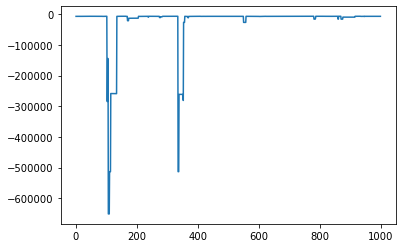

In [25]:
plt.plot(np.r_[:len(nb_mcmc.ll_iter)], nb_mcmc.ll_iter)

In [36]:
len(nb_mcmc.clusters[1].ll_traces)

79

In [44]:
nb_mcmc.ll_iter

[]

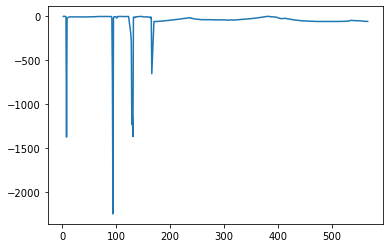

In [29]:
msk = (nb_mcmc.clusters[1].ll_traces[4] != 0)
plt.plot(np.r_[:len(nb_mcmc.clusters[1].ll_traces[4])][msk], nb_mcmc.clusters[1].ll_traces[4][msk])

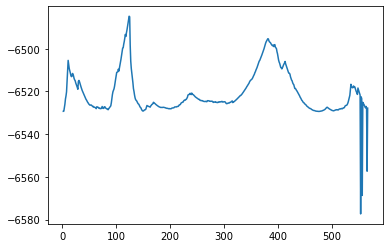

In [31]:
trace = nb_mcmc.clusters[1].ll_traces[1]
nonzero = (trace != 0)
msk2 = (trace > trace.mean()*1.025)
msk = nonzero & msk2
plt.plot(np.r_[:len(trace)][msk], trace[msk])

In [26]:
len(nb_mcmc.clusters[1].phase_history)

64

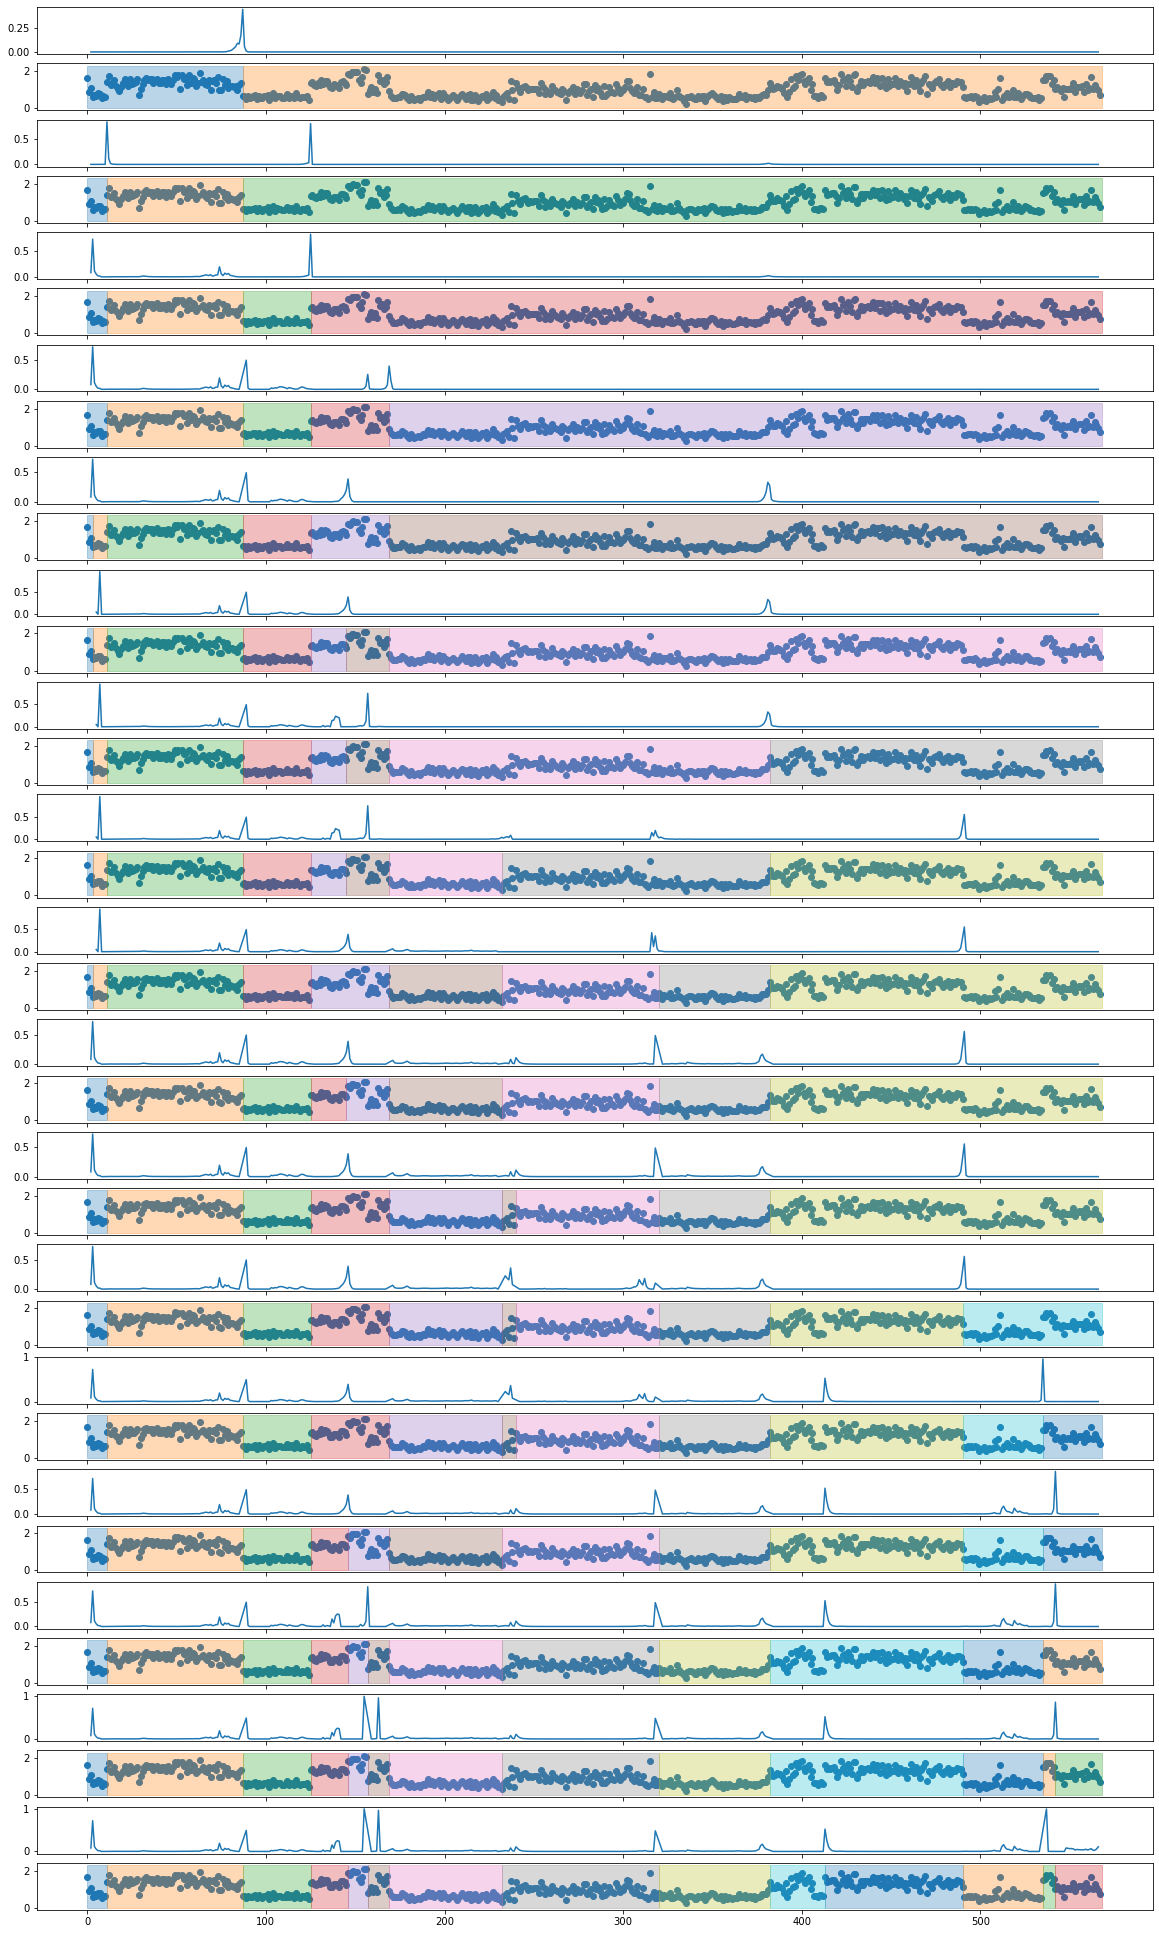

In [34]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,35), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = np.exp(traces[i])
    nonzero = (trace != 1)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

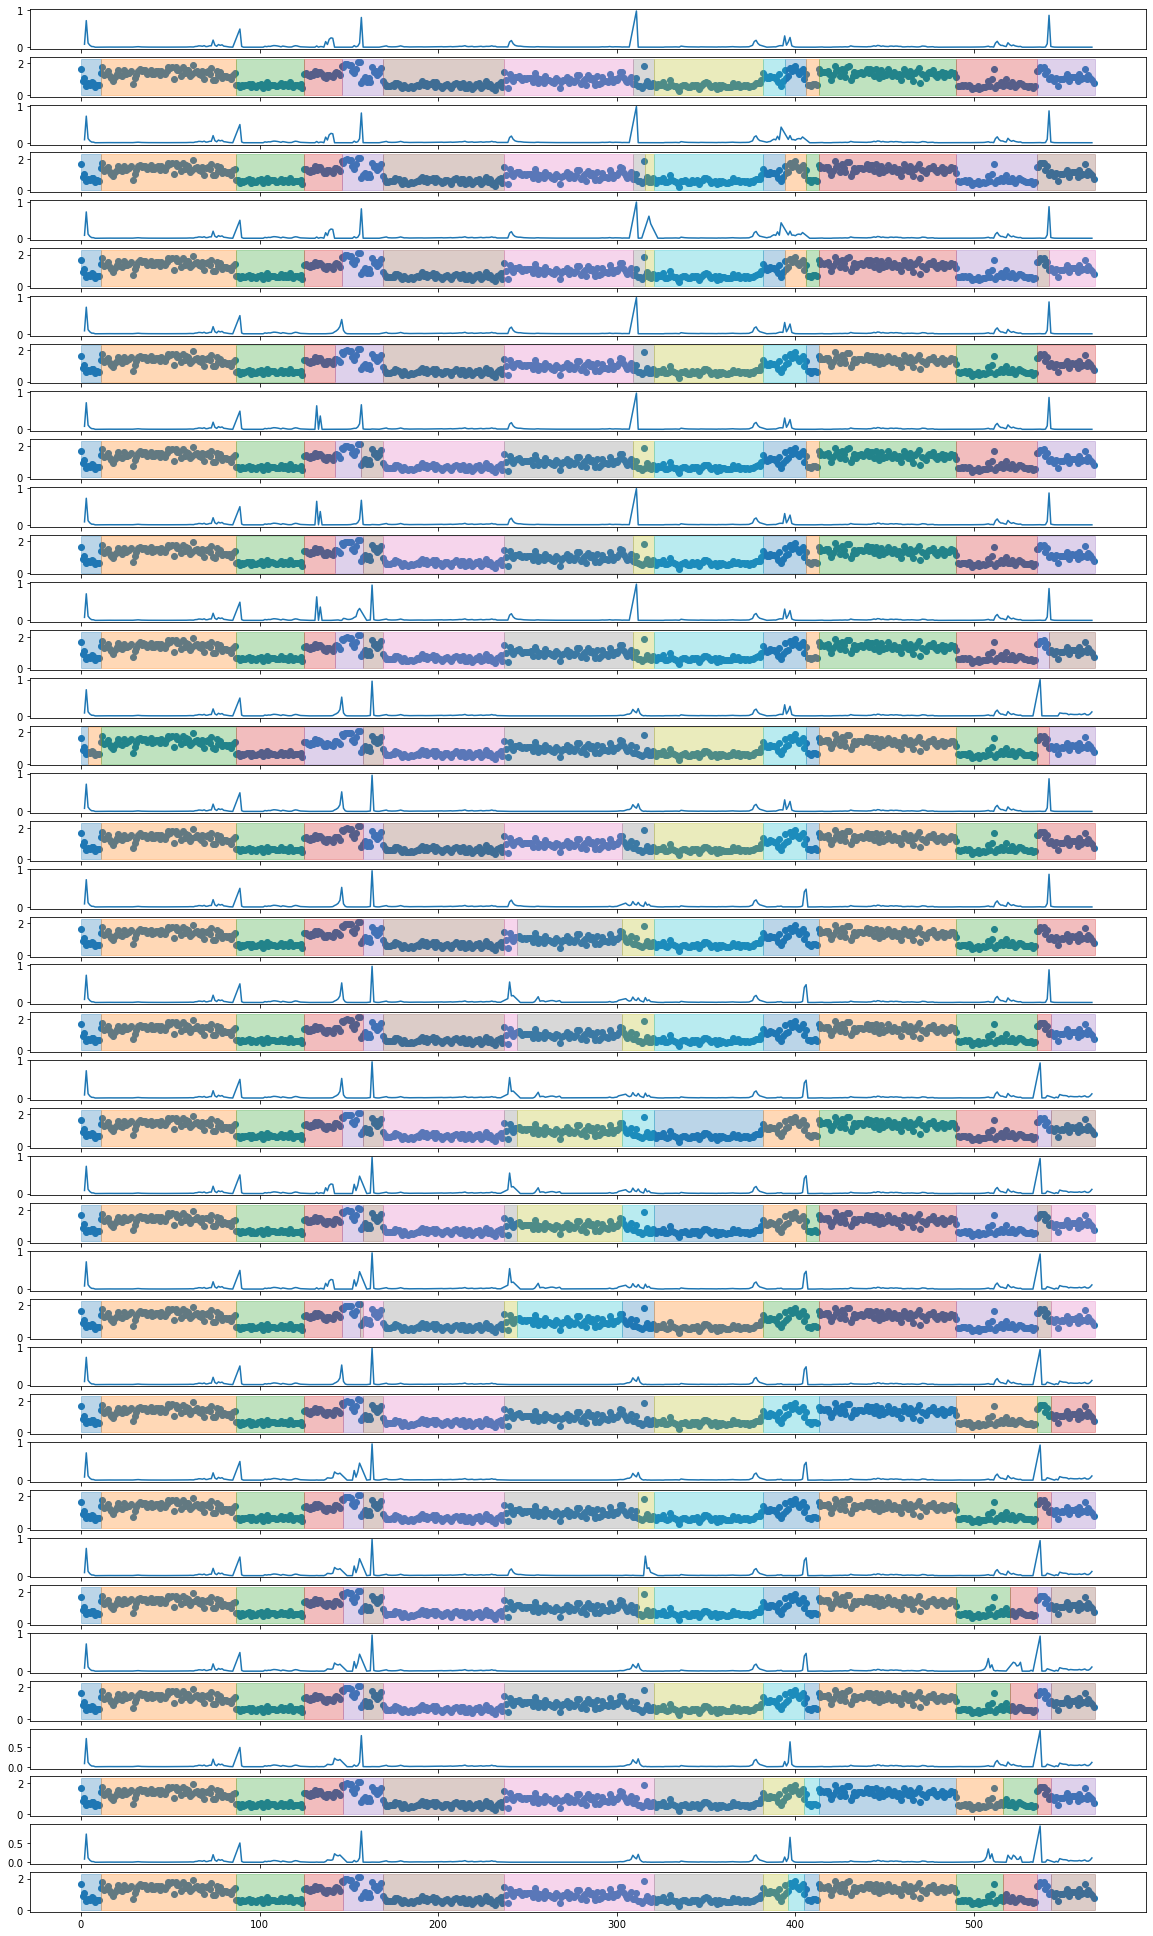

In [43]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * 20, figsize = (20,35), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i, t in enumerate(np.r_[len(traces)-20:len(traces)]):
    trace = np.exp(traces[t])
    nonzero = (trace != 1)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[t]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

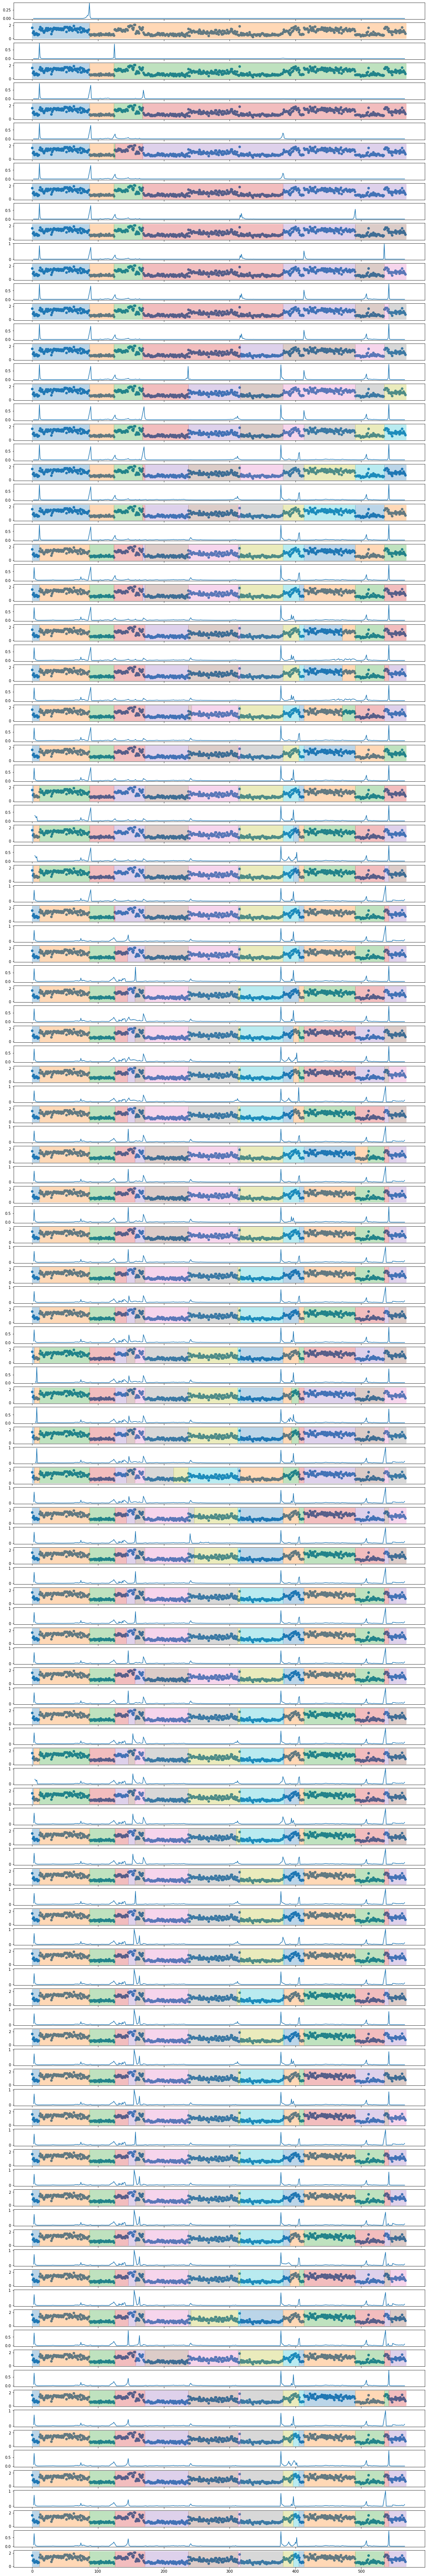

In [27]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,2 * len(traces)), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = np.exp(traces[i])
    nonzero = (trace != 1)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

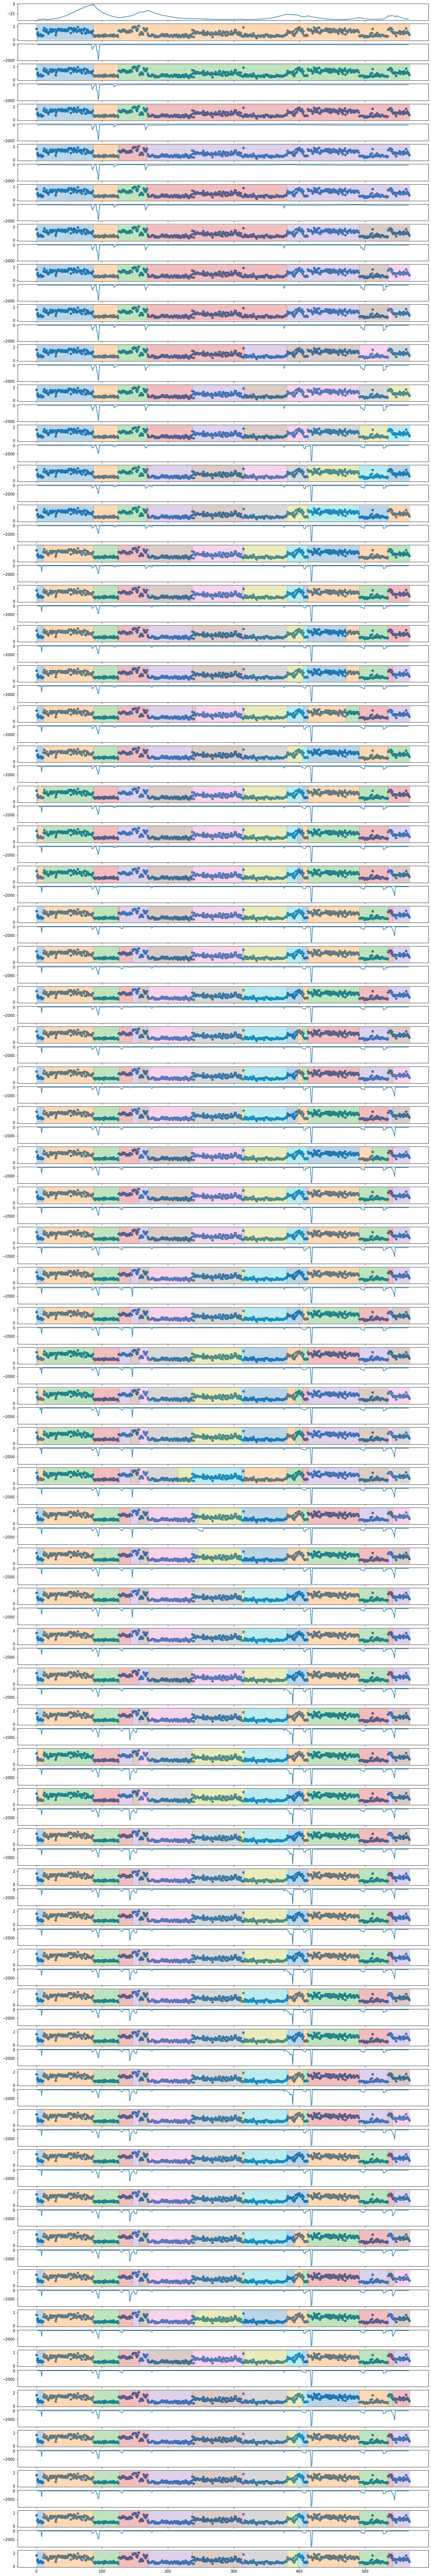

In [28]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,2 * len(traces)), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = traces[i]
    nonzero = (trace != 0)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))